# Clarification on related post-hoc interpretation methods

*(best downloaded and viewed locally instead of the GitHub preview)*

During the RecSys conference, it appeared that it was not clear how our method was different from popular post-hoc ones. The issue is that many conceptually different methods aim to providing interpretations at the input feature level. Typically the goal is to assign a feature "importance" value to each component. There are axioms that are shared accross many methods: the interpretation values should be permutation-invariant, mean-shift invariant, and should be zero if the feature is a nuisance variable, ... But beyond these, the provided interpretations, nature of the computed feature importance value, range of applicability of the method, ... can vary widely.

It is important to distinguish two classes of interpretation methods that relate a model input to its output, we will name them:
- **sensitivity task**: if we change a feature, by how much is the prediction expected to change?
- **attribution task**: what features were the most useful to make the prediction?

The interpretation provided by those two tasks are very different, sensitivity is somewhat the local derivative of attribution. We must also underline that sensitivity can be computed in polynomial time, while attribution is NP. That is why many method resort to approximation of attribution (as the simple *Input$\times$Gradient* method), or make assumption on the attribution candidate space (eg. GAM, GA^2M, our method 👋, ...).

That's why we can generally make another distinction between the methods:
- **post-hoc**: we assume a model has been trained to model the mapping of the input to the output, and we use this mapping to explain the instances. Many modern methods in this category require a sampling mechanism to provide an interpretation, which can be time-consuming. To put it as a take-away, *training is fast, interpretation is slow*.
- **intrinsic**: everything is possible, but the point is to train a model to jointly predict and interpret the data. Training is often more complex than standard models, but the interpretation are often computed in a single feed-forward pass. Here, *training is slow, interpretation is fast*. Of course, this is not an absolute rule.


All the post-hoc methods I know of provide an approximation of attribution. We show the differences and limitations of those methods using a visual comparaison on simple synthetic tasks.

<span style='text-decoration:underline'>Summary of the experiments to follow:</span>

| *Methods* | Gradient | Gradient $\times$ Input | LIME | Integrated Gradient | SHAP | <span style='color:#00F'>Our method</span> |
| ------: |:--------:| :----------------------:|:---: |:-------------------:|:----:|:----------:|
| Shift-invariance                | ✅ |   | ✅ | ✅ | ✅ | ✅ |
| Sensitivity                     | ✅ |   | ✅ |   |   |   |
| Global attribution univariate | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ |
| Global attribution high-order |   |   |   |   |   | ✅ |
| Local attribution univariate  |   |   |   |   | ✅ | ✅ |
| Local attribution high-order  |   |   |   |   |   | ✅ |

# 0 - Preliminary

In this notebook, we will study bidimensional problems with binary labels. The input random variable will be denoted by $X$, with codomain $\mathbb{R}^2$ , the target binary label by $Y$, with codomain $\{0, 1\}$. Samples of these variables will be written in lowercase: $x \sim X$, $y \sim Y$. The probability distribution will be written $p_X(x)$ for $X$, $p_{X,Y}(x,y) = p(y|x)p_X(x)$ for the joint law. We will refer to $p(y|x)$ as a "mapping" from $X$ to $Y$, which is an abuse of notation taken from regression problems.

**What is the attribution problem?**

For each point $x = (x_1, x_2)$ we want to know if we can predict the label of $x$ by either using its component $x_1$, $x_2$ or both components $(x_1, x_2)$. We can also write this as a goal of finding a set of indices $s$ among $\{1\}$, $\{2\}$ or $\{1,2\}$, and then we must be able to predict a label $y$ associated to $x$ by only knowing $x_{|s}$. 

There are two settings for attribution:
- **global attribution**: we want to find a unique set $s$ that will work everywhere such that we have good performances at predicting $Y$ from $X_{|s}$. Global attribution is typically used to reduce variance by ignoring noisy features.
- **local attribution**: the indice set depends on the instance $x$: $s(x)$. If we write $s$ as a set that is sampled from a random variable $S$, then we want to predict $Y$ from $X_{|S}$.

Note: local attribution $\neq$ sensitivity, local attribution is a difficult task where we estimate the contribution of each instance with respect to every other instance. Sensitivity only focuses on an instance and its neighborhood.

**How do we solve the attribution problem**

Many different methods exist. It is important to understand that attribution is NP-hard. Thus, **any method solving attribution in polynomial time is making a approximation of attribution**. In our paper, we suppose that the values that $S$ can take can be reduced from $2^n$ candidates to only a reasonable number $H$ of possibilities. In the SHAP paper, the implicit assumption is that we can reduce the space to the sole study of univariate contributions, hence a $n$ candidate space. And so on.

**How do we know if we have the right attribution solution**

Damn good question. I voluntarily defined attribution in vague terms ("having good performances"), because most methods define attribution their own way. Another issue is that we generally do not have ground-truth for attribution, we only have access to a sample of data with inputs and labels. That's why many methods evaluate interpretation quality by confirming that the solution correspond to intuition, or underlying knowledge of the data, or conduct user studies to check that the top attributed feature is coherent. Making complex attribution scenarii uncheckable...

... but this is not entirely true. Because we can use synthetic datasets, at least to check that on those tasks, the methods provide the right solutions. We will derive attribution solutions in the following sections.

Take the case of global attribution, our goal is to find the smallest subset $s$ such that $Y$ can be roughly predicted from $X_{|s}$. This translates as:
$$\min \textrm{Card}(s), \; \textrm{such that} \; \forall x, y, \; p(y|x) \simeq p(y|x_s)$$
The $\simeq$ allows a margin of error to account for noise.

**Note: attribution visualisation**

In this notebook, we are dealing with bidimensional inputs, and we have three possible attribution responses: $\{1\}$, $\{2\}$ or $\{1,2\}$. To visualise the solution for all instances, we use a color-code:
- an attribution to the first component ($x_1$) will be displayed with a red color 
- an attribution to the second component ($x_2$) will be displayed with a green color

For the attribution to $\{1,2\}$, we have two cases. We either consider a **subset attribution** problem, where answering $\{1,2\}$ is different from co-answering the two univariate solution $\{1\}$ and $\{2\}$, and then we will use a blue color. Or else we consider a **feature attribution** setting, where $\{1,2\}$ and $\{\{1\},\{2\}\}$ are undistinguishable, then we will use a yellow color (the combinaison of the red and the green color).

This will get more clear with the examples developped in the next sections.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
print('TF version:', tf.__version__)

plt.style.use('seaborn')
plt.set_cmap('viridis')
# g_cmap = sns.diverging_palette(240, 10, n=7, as_cmap=True)

%matplotlib inline

TF version: 2.3.0


In [2]:
''' Utils '''

def sample(pyx):
    ''' Sample binary variable from probability distribution '''
    eps = tf.random.uniform(pyx.shape, 0, 1)
    return tf.cast(eps < pyx, 'float32')

def wrap_prob(pred):
    ''' p(Y=1|X=x) -> p(Y|X=x) '''
    def f(x):
        y = pred(x)
        y = np.expand_dims(y, -1)
        return np.concatenate([y, 1 - y], axis=-1)
    return f

def make_generator(func, params):
    ''' For tf.keras fit() function '''
    while True:
        yield func(**params)

def l1_normalisation(x):
    return x / (1e-9 + tf.reduce_sum(tf.math.abs(x), axis=-1, keepdims=True))

def l2_normalisation(x):
    return x / (1e-9 + tf.math.sqrt(tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)))

## 1 - XOR: a study on <span style='color:#00F'>feature interactions</span>

Attribution means that we want to model a function dependence to a set of variables. If only one variable is globally dominant to make a prediction, post-hoc gradient methods are fine! But for real-data tasks, only considering univariate contributions would be as limiting as restricting ourselves to linear regressions instead of using higher-order models.

We study the simplest case of feature interaction: the XOR problem. It can be formulated in many ways, we choose to implement it as a bidimensional problem with distribution $p(Y=1|X=(x_1, x_2)) = \textrm{sigmoid}(x_1x_2)$.

The distribution is plotted below. The XOR distribution is an odd function and thus intrinsically bidimensional: if we ignore either $x_1$ or $x_2$, the distribution we obtain is a random noise as we supperpose instances with opposite labels, ie. $p(Y=1 | X_1=x1) = p(Y=1 | X_2=x2) = 0.5$. So, _any method not returning the two input variables as an attribution solution is wrong_.

We will show that most post-hoc methods are not correlated with the ground-truth attribution (but some correlate with the ground-truth sensitivity). Note that those methods were not necessarily intended to provide attribution, but they are often used in practice as such.

In [3]:
def true_pyx(x): 
    ''' p(Y=1|X=x) -- instead of training a model, we provide the true distribution and avoid the approximation error '''
    return tf.nn.sigmoid(x[:,0] * x[:,1])

def true_grad_pyx(x):
    ''' The expresssion is simple enough for us to compute the gradient directly '''
    pyx = tf.expand_dims(true_pyx(x), -1)
    return tf.tile(pyx * (1 - pyx), (1, 2)) * tf.roll(x, 1, axis=-1)

def true_normalised_grad_pyx(x):
    ''' We normalise the gradient to only have an attribution ratio between the variables. '''
    normed_grad = tf.roll(x, 1, axis=-1)
    return l1_normalisation(normed_grad)

In [4]:
X_train = tf.random.uniform((2000, 2), -4, 4)  # p_X = U(-4,4) * U(-4,4)
Y_train = sample(true_pyx(X_train))

N = 50  # mesh input space
gx, gy = np.meshgrid(np.linspace(-4, 4, N), np.linspace(-4, 4, N))
G = np.concatenate([gx.reshape((-1, 1)), gy.reshape((-1, 1))], axis=-1)
x = tf.convert_to_tensor(G, 'float32')

Text(0, 0.5, 'x2')

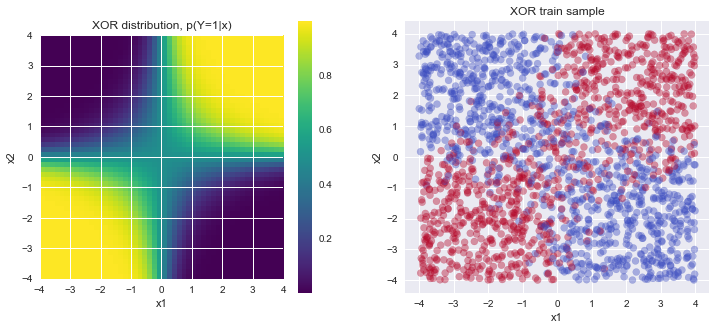

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
y = true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.title('XOR distribution, p(Y=1|x)'); plt.xlabel('x1'); plt.ylabel('x2')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, alpha=0.4, cmap='coolwarm')
plt.title('XOR train sample'); plt.xlabel('x1'); plt.ylabel('x2')

As mentioned, we show that when we ignore either of the two input variables, everything is merged together and not separable:

Text(0, 0.5, 'y')

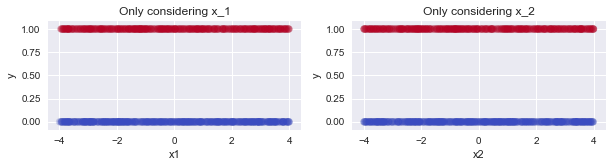

In [6]:
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:,0], Y_train, c=Y_train, alpha=0.1, cmap='coolwarm')
plt.title('Only considering x_1'); plt.xlabel('x1'); plt.ylabel('y')
plt.subplot(1, 2, 2)
plt.scatter(X_train[:,1], Y_train, c=Y_train, alpha=0.1, cmap='coolwarm')
plt.title('Only considering x_2'); plt.xlabel('x2'); plt.ylabel('y')

ie. it is not possible to train a model to learn either $X_1 \mapsto Y$ or $X_2 \mapsto Y$, other than one predicting a uninformative constant value $0.5$.

*Proof:* $p(Y=1|X=x) - 0.5 = \frac{1}{2}\tanh(\frac{1}{2}x_1x_2)$, and thus is an odd function in $x_1$ and $x_2$. Computing the expected mapping from $X$ to target variable $Y$ reduced to the knowledge of only $X_1$ we obtain
$$\mathbb{E}_X[Y|X_1=x_1] = \frac{1}{2}(\mathbb{E}_{X_2 > 0}[Y|X_1=x_1] + \mathbb{E}_{X_2 \leq 0}[Y|X_1=x_1])$$
$$= \frac{1}{2} \left( \int_{z_2 > 0} p(Y=1|x_1, z_2)dz_2 - 0.5 + \int_{z_2 \leq 0} p(Y=1|x_1, z_2)dz_2 - 0.5 \right) + 0.5$$
$$= \frac{1}{2} \left( \int_{z_2 > 0} (p(Y=1|x_1, z_2) - 0.5)dz_2 - \int_{z_2 \geq 0} (p(Y=1|x_1, z_2) - 0.5)dz_2 \right) + 0.5$$ 
$$=0.5$$
By symmetry, we also have $\mathbb{E}_X[Y|X_2=x_2] = 0.5$.

### a - Raw gradient

We first look at the results by the simplest saliency method: computing the gradient of our model with respect to its inputs. Here we use the true distribution of $Y|X$ as model, we have no approximation nor optimisation error, the only possible errors are due to the interpretation method.

This method uses the absolute value of the gradient as indicator of the most salient features. We will plot the attribution solution on an image, by using the <span style='color:#F02'>red</span> channel as $x_1$ attribution, and <span style='color:#082'>green</span> for $x_2$. As explained, a XOR distribution is a problem with pure feature interaction, so **the ground-truth image is <span style='color:#D90'>yellow</span>** (an addition of the red and green color).

Note that the gradient methods provide a **feature** importance measure, but it is impossible to distinguish between an attribution to $\{x_1, x_2\}$ and the case where both $\{x_1\}$ and $\{x_2\}$ are univariate solutions. For that, we need a **subset** importance measure, that generalised additive models and our method provide.

Text(0, 0.5, 'x2')

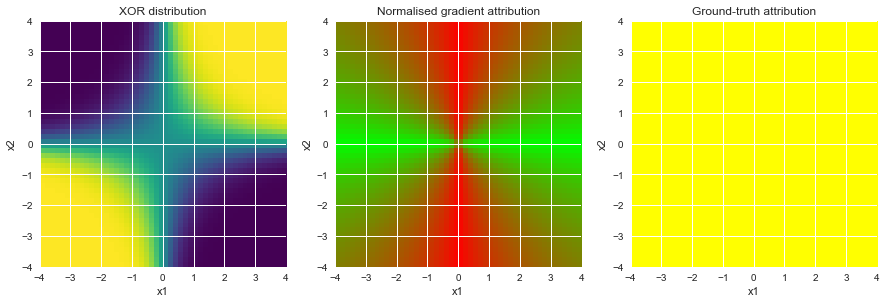

In [7]:
simple_grad = tf.abs(true_normalised_grad_pyx(x))
simple_grad_img = np.zeros((N,N,3))
simple_grad_img[:,:,:2] = simple_grad.numpy().reshape((N,N,-1))

ground_truth_img = np.ones((N,N,3))
ground_truth_img[:,:,2] = 0.

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
y = true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.title('XOR distribution'); plt.xlabel('x1'); plt.ylabel('x2')
plt.subplot(1, 3, 2)
plt.imshow(simple_grad_img, extent=[-4, 4, -4, 4])
plt.title('Normalised gradient attribution'); plt.xlabel('x1'); plt.ylabel('x2')
plt.subplot(1, 3, 3)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Gradient does not provide an attribution solution, but a **sensitivity map**.

Another method is gradient times input. Let's see what we get. 

Text(0, 0.5, 'x2')

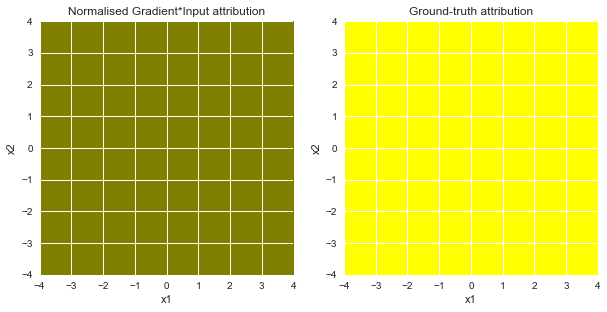

In [8]:
grad_input = tf.abs(true_normalised_grad_pyx(x) * x)
grad_input = l1_normalisation(grad_input)  # convert to a ratio between features

grad_input_img = np.zeros((N,N,3))
grad_input_img[:,:,:2] = grad_input.numpy().reshape((N,N,-1))

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(grad_input_img, extent=[-4, 4, -4, 4])
plt.title('Normalised Gradient*Input attribution'); plt.xlabel('x1'); plt.ylabel('x2')
plt.subplot(1,2,2)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

We seem to have the right attribution solution. Even if it needed normalisation and does not have maximal values on $x_1$ and $x_2$.

However, in general, gradient\*input methods, though providing here the right solution, are not robust to mean shifts, which are a necessary property of attribution methods. For instance, if we shift the distribution by $(1, 1)$:

Text(0, 0.5, 'x2')

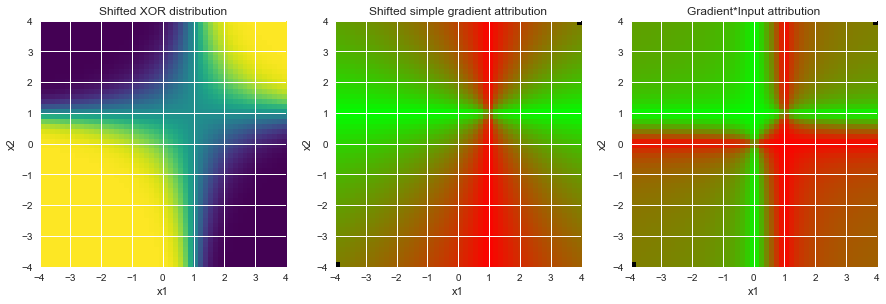

In [9]:
def shifted_true_pyx(x): 
    ''' Instead of training a model, we provide the true distribution and avoid the approximation error '''
    return tf.nn.sigmoid((x[:,0] - 1) * (x[:,1] - 1))

def shifted_true_grad_pyx(x):
    ''' The expresssion is simple enough for us to compute the gradient directly '''
    y = tf.expand_dims(true_pyx(x), -1)
    return tf.tile(y * (1 - y), (1, 2)) * tf.roll(x - 1, 1, axis=-1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
y = shifted_true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.title('Shifted XOR distribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)  # for information, we compute simple gradient again
simple_grad = tf.abs(shifted_true_grad_pyx(x))
simple_grad = l1_normalisation(simple_grad)  # convert to a ratio between features
simple_grad_img = np.zeros((N,N,3))
simple_grad_img[:,:,:2] = simple_grad.numpy().reshape((N,N,-1))
plt.imshow(simple_grad_img, extent=[-4, 4, -4, 4], origin='lower')
plt.title('Shifted simple gradient attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
grad_input = tf.abs(shifted_true_grad_pyx(x) * x)
grad_input = l1_normalisation(grad_input)  # convert to a ratio between features
grad_input_img = np.zeros((N,N,3))
grad_input_img[:,:,:2] = grad_input.numpy().reshape((N,N,-1))
plt.imshow(grad_input_img, extent=[-4, 4, -4, 4], origin='lower')
plt.title('Gradient*Input attribution'); plt.xlabel('x1'); plt.ylabel('x2')

It fails to find the right solution with this shift. The right solution was but a particular case.

### b - LIME

LIME is not so different from a gradient method. It is painfully slow to compute for many instances as it is not assumed that we have access to the model gradient and needs to sample many points around each instance. We use the official library for fair comparison.  

In [10]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=False)

In [11]:
N = 50
lime_img = np.zeros((N,N,3))

predictor = wrap_prob(true_pyx)  # we use the true dist as predictor oracle
for i in range(N):
    for j in range(N):
        x1 = -4 + (8. * i)/N
        x2 = -4 + (8. * j)/N
        point = np.array([x1, x2], 'float32')
        exp = explainer.explain_instance(point, predictor, num_features=2, num_samples=1000).as_list()
        lime_img[j,i,int(exp[0][0])] = exp[0][1]
        lime_img[j,i,int(exp[0][1])] = exp[1][1]

The raw interpretation of LIME can have negative values (*spoiler*: because LIME solves a sensitivity task, not an attribution task). If we use the absolute value as a measure of attribution:

Text(0, 0.5, 'x2')

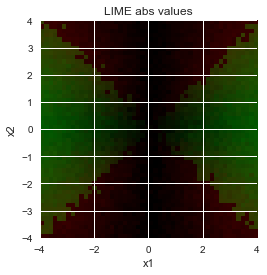

In [12]:
plt.imshow(np.abs(lime_img), extent=[-4, 4, -4, 4], origin='lower')
plt.title('LIME abs values'); plt.xlabel('x1'); plt.ylabel('x2')

The raw values are too low. Most practionner are only insterested in the relative weights of features importance, so we normalise the values to see them.

Text(0, 0.5, 'x2')

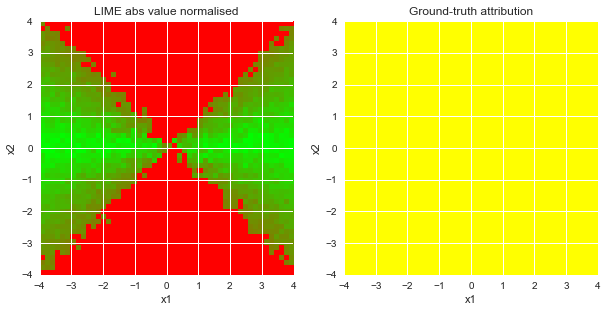

In [13]:
lime_img_2 = l1_normalisation(np.abs(lime_img))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(lime_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.title('LIME abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')
plt.subplot(1,2,2)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

LIME was not intended to solve an attribution task, but it does allow to solve a sensitivity task. Compared to the simple gradient method, the map is sharper since LIME computes a LASSO regressor with $L_1$ penality, a single feature is encouraged in the transition regions.

### c - SmoothGrad

SmoothGrad allows to remove noise from the gradient estimates, it is particularly efficient for images. Here we have access to the true gradient, so the results won't be different from simple gradient methods.

### d - Integrated Gradient

Integrated gradient was designed to provide solution to the attribution task.

One detail in the implementation of integrated gradient is the choice of a baseline point to compare instances to. Here we choose the origin as baseline, which has symmetric properties and an equiprobable label. We will indicate it with a red cross on our plots.

In [14]:
def integrated_gradients(baseline, point, grad_func, m_steps=20):
    ''' I adapt the code from
    https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
    '''
    def integral_approximation(gradients):
        grads = (gradients[:-1] + gradients[1:]) / 2.
        return tf.math.reduce_mean(grads, axis=0)

    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    path = tf.expand_dims(baseline, 0) + tf.expand_dims(point - baseline, 0) * tf.expand_dims(alphas, 1)
    grad_path = grad_func(path)
    int_grad = integral_approximation(grad_path)
    integrated_gradients = (point - baseline) * int_grad

    return integrated_gradients

N = 50
intgrad_img = np.zeros((N,N,3))
baseline_point = np.array([0., 0.], 'float32')

for i in range(N):
    for j in range(N):
        x1 = -4 + (8. * i)/N
        x2 = -4 + (8. * j)/N
        point = np.array([x1, x2], 'float32')
        exp = integrated_gradients(baseline_point, point, true_grad_pyx)
        intgrad_img[j,i,:2] = exp

Text(0, 0.5, 'x2')

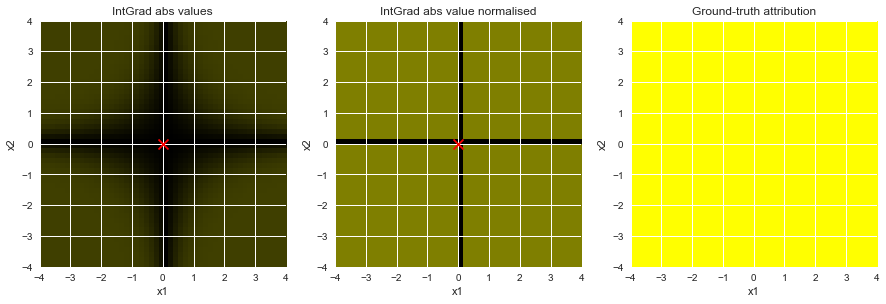

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.abs(intgrad_img), extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs values'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1,3,2)
intgrad_img_2 = l1_normalisation(np.abs(intgrad_img))
plt.imshow(intgrad_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1,3,3)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

As in the case of Input\*Gradient, it seems that we have the right attribution.

And additionally, for a shifted distribution:

Text(0, 0.5, 'x2')

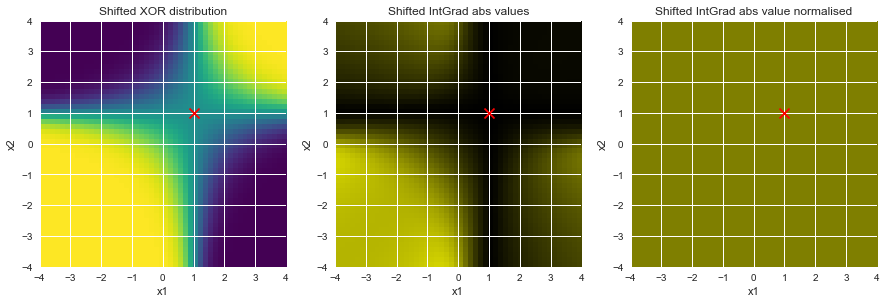

In [16]:
N = 50
intgrad_shift_img = np.zeros((N,N,3))
baseline_point = np.array([1., 1.], 'float32')  # we also shift the baseline null region

for i in range(N):
    for j in range(N):
        x1 = -4 + (8. * i)/N
        x2 = -4 + (8. * j)/N
        point = np.array([x1, x2], 'float32')
        exp = integrated_gradients(baseline_point, point, shifted_true_grad_pyx)
        intgrad_shift_img[j,i,:2] = exp

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
y = shifted_true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('Shifted XOR distribution'); plt.xlabel('x1'); plt.ylabel('x2')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(intgrad_shift_img), extent=[-4, 4, -4, 4], origin='lower')
plt.title('Shifted IntGrad abs values'); plt.xlabel('x1'); plt.ylabel('x2')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.subplot(1, 3, 3)
intgrad_shift_img_2 = l1_normalisation(np.abs(intgrad_shift_img))
plt.imshow(intgrad_shift_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('Shifted IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

Again, we seem to get the right attribution.

But were those just particular cases, as in the case of gradient\*input? Well, look what happens when we displace just a little the baseline point to another relevant region where the labels are equiprobable: $(0.5, 0)$. Note that we do not cherry-pick this baseline, any small displacement around the origin works the same. It falls in the definition of the baseline given in the original paper:
> A common way for humans to perform attribution relies on counterfactual intuition. When we assign blame to a certain cause we implicitly consider the absence of the cause as a baseline for comparing outcomes. In a deep network, we model the absence using a single baseline input. For most deep networks, a natural baseline exists in the input space where the prediction is neutral. For instance, in object recognition networks, it is the black image. 

Text(0, 0.5, 'x2')

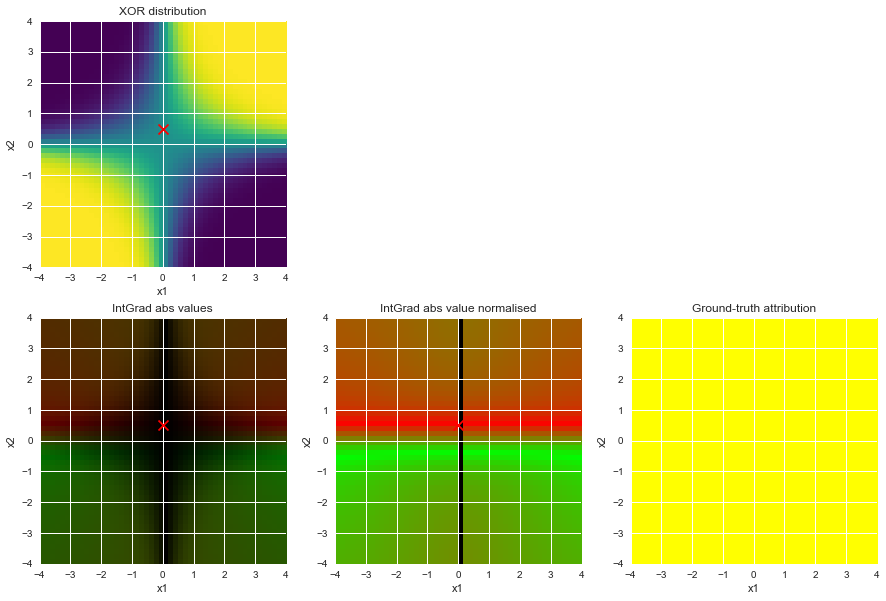

In [17]:
N = 50
intgrad_otherbaseline_img = np.zeros((N,N,3))
baseline_point = np.array([0., 0.5], 'float32')  # small displacement of the baseline

for i in range(N):
    for j in range(N):
        x1 = -4 + (8. * i)/N
        x2 = -4 + (8. * j)/N
        point = np.array([x1, x2], 'float32')
        exp = integrated_gradients(baseline_point, point, true_grad_pyx)
        intgrad_otherbaseline_img[j,i,:2] = exp

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
y = true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('XOR distribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,3,4)
plt.imshow(np.abs(intgrad_otherbaseline_img), extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs values'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,3,5)
intgrad_img_2 = l1_normalisation(np.abs(intgrad_otherbaseline_img))
plt.imshow(intgrad_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,3,6)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

We see that **the solution completely collapses** when moving the baseline just a bit. The right solutions we found were just particular cases.
For real-data tasks, the choice of a baseline is even less natural. If the method is not robust to a small displacement on a very smooth synthetic task (and where we still found a region of perfectly equiprobable labels), it is dubious it generalises well.

### e - SHAP

(SHAP was not designed to deal with interactions.)

As we are dealing with a pure feature interaction task, we cannot have the feature independance assumption of the SHAP paper, nor the model linearity. So the `KernelExplainer` will fail with this example. `GradientExplainer` comes from a more recent paper and improves over the integrated gradient method. Let's see how it fares.

In [18]:
import shap

from tensorflow.keras.layers import Input, Lambda

inputs = Input((2,))
output = Lambda(true_pyx)(inputs)
predictor = tf.keras.Model(inputs, output)  # oracle

expl = shap.GradientExplainer(predictor, X_train, batch_size=500)

In [19]:
# shap_val = expl.shap_values(np.array([[4.,0.], [0., 0.], [0., 4.], [4., 4.]], 'float32'))
N = 50  # mesh input space
gx, gy = np.meshgrid(np.linspace(-4, 4, N), np.linspace(-4, 4, N))
G = np.concatenate([gx.reshape((-1, 1)), gy.reshape((-1, 1))], axis=-1)

shap_val = expl.shap_values(G)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Text(0, 0.5, 'x2')

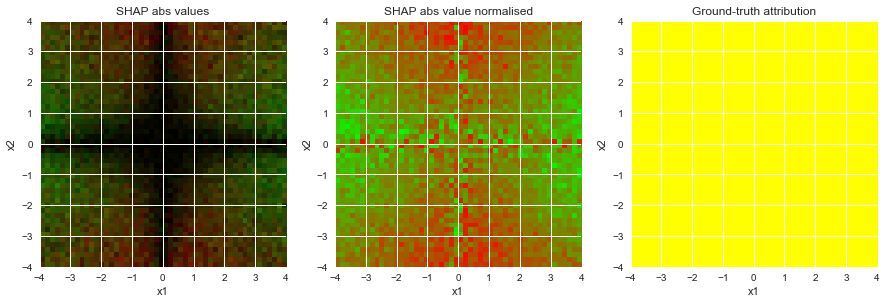

In [20]:
shap_img = np.zeros((N,N,3))
shap_img[:,:,:2] = shap_val.reshape((N,N,2))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.abs(shap_img), extent=[-4, 4, -4, 4], origin='lower')
plt.title('SHAP abs values'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1,3,2)
shap_img_2 = l1_normalisation(np.abs(shap_img))
plt.imshow(shap_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.title('SHAP abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1,3,3)
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4])
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

It is not good at all. It somehow ressembles a sensitivity map, but noisier.

### Conclusion

All the post-hoc methods we try fail at returning the attribution solution of this simple XOR task. We did provide the oracle mapping from $X \mapsto Y$, which is the best possible predictor to work with in a post-hoc setting, with real models, we would have additional errors.

Arguably, the difficulty of the XOR problem is the feature interaction that many methods were not designed to handle, often by making the assumption that input features contributions are additive. For a real-data applications, is it however paramount to be able to overcome those cases.

### <span style='color:#00F'>Our method</span>

It is not a post-hoc method, we have to train a model, which may produce errors with the approximation and the optimisation.

A second observation is that our method yields **subset attribution**, allowing to normalise things correctly. Here, if we attribute the <span style='color:#F00'>red</span> channel to the subset $\{x_1\}$, <span style='color:#082'>green</span> to $\{x_2\}$ and add the new channel <span style='color:#00F'>blue</span> as $\{x_1, x_2\}$, the solution of attribution is no longer a yellow image, but a <span style='color:#00F'>blue</span> image.

In [21]:
import sys
sys.path.append('../models')
from multilayered_nn import *

In [22]:
tf.keras.backend.clear_session()
params = {
    'input_dim': (2,),
    'hidden_layers_dims': [32, 16],
    'activation': 'relu',
    
    'input_node_partition': [(0, 1), (1, 2)],
    'attribution_subsets':  [(True, False), (False, True), (True, True)],  # all possible candidates
}

m = Attr_Binary_FF_list(params)
m.compile(tf.keras.optimizers.Adam(1e-3))

In [23]:
def batch_gen(bs=256):
    X_train = tf.random.uniform((bs, 2), -4, 4)  # p_X = U(-4,4) * U(-4,4)
    Y_train = sample(true_pyx(X_train))
    return X_train, Y_train

data_gen = make_generator(batch_gen, {})
m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
500/500 - 1s - loss: 0.5691 - acc: 0.8567
Epoch 2/30
500/500 - 1s - loss: 0.5593 - acc: 0.8639
Epoch 3/30
500/500 - 1s - loss: 0.5580 - acc: 0.8639
Epoch 4/30
500/500 - 1s - loss: 0.5571 - acc: 0.8644
Epoch 5/30
500/500 - 1s - loss: 0.5564 - acc: 0.8642
Epoch 6/30
500/500 - 1s - loss: 0.5569 - acc: 0.8633
Epoch 7/30
500/500 - 1s - loss: 0.5561 - acc: 0.8636
Epoch 8/30
500/500 - 1s - loss: 0.5556 - acc: 0.8646
Epoch 9/30
500/500 - 1s - loss: 0.5566 - acc: 0.8626
Epoch 10/30
500/500 - 1s - loss: 0.5564 - acc: 0.8632
Epoch 11/30
500/500 - 1s - loss: 0.5566 - acc: 0.8619
Epoch 12/30
500/500 - 1s - loss: 0.5568 - acc: 0.8620
Epoch 13/30
500/500 - 1s - loss: 0.5563 - acc: 0.8638
Epoch 14/30
500/500 - 1s - loss: 0.5568 - acc: 0.8637
Epoch 15/30
500/500 - 1s - loss: 0.5562 - acc: 0.8642
Epoch 16/30
500/500 - 1s - loss: 0.5568 - acc: 0.8635
Epoch 17/30
500/500 - 1s - 

Text(0, 0.5, 'x2')

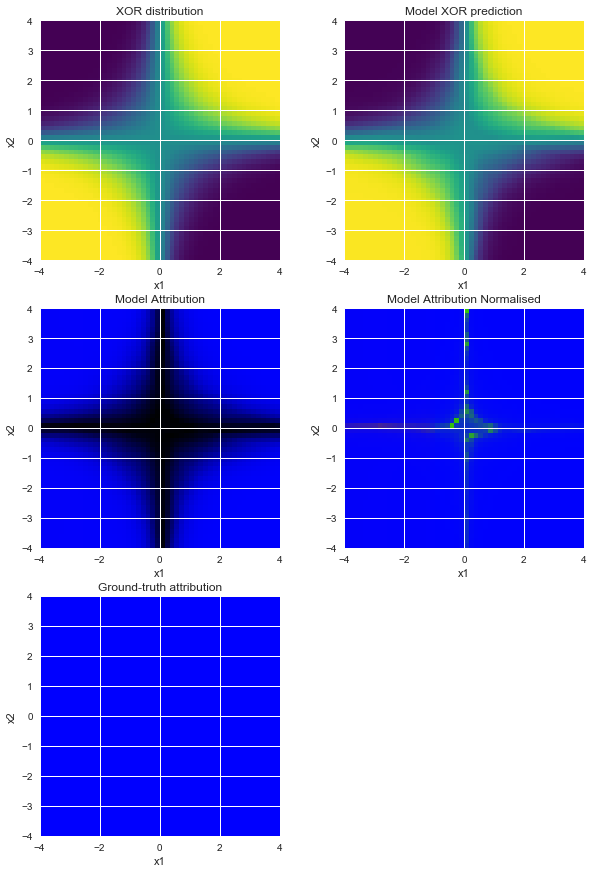

In [24]:
pred_experts = m.model_int.predict(G)
attr = get_attributions(pred_experts, m.C_residual)
pred = MoE(pred_experts, m.C_residual, mode='L1')
attr_img = attr.numpy().reshape((N,N,3))

attr_img_2 = l1_normalisation(attr_img)

plt.figure(figsize=(10, 15))
plt.subplot(3,2,1)
y = true_pyx(x)
plt.imshow(y.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.title('XOR distribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(3,2,2)
plt.imshow(pred.numpy().reshape((N,N)), extent=[-4, 4, -4, 4], origin='lower')
plt.title('Model XOR prediction'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(3,2,3)
plt.imshow(attr_img, extent=[-4, 4, -4, 4], origin='lower')
plt.title('Model Attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(3,2,4)
plt.imshow(attr_img_2, extent=[-4, 4, -4, 4], origin='lower')
plt.title('Model Attribution Normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(3,2,5)
ground_truth_img = np.zeros((N,N,3))
ground_truth_img[:,:,2] = 1
plt.imshow(ground_truth_img, extent=[-4, 4, -4, 4], origin='lower')
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Apart from small errors along the central axis where the labels are the most noisy, our method allows to get a correct attribution solution, and thanks to the subset formulation, to correctly normalise them.

## 2 - Toy problem (a): a study on <span style='color:#00F'>local univariate attribution<span>

The previous section, we showed that many methods fail to provide the right attribution with a global feature interaction. We move back to a task where the attribution will be a single feature. However, we now study a problem where attribution can vary in different regions of space.

For that, we will study the toy problem (a) we introduced in our paper. We derive again the ground-truth local attribution from our paper. We will see that it is paramount to not only consider the mapping $p(y|x)$ but also the input distribution $p(x)$. $p(X)$ is as important as $p(Y|X)$ to obtain the right interpretations, we show that gradient methods and other "local" methods fail at providing the right interpretations.
    
We consider the synthetic data distribution:
$$p(Y=1|X=(x_1, x_2)) = \textrm{sigmoid}(x_1 + x_2)$$
$$X \sim \frac{1}{4} \left[ \mathcal{N}((-\mu, 0), \sigma) + \mathcal{N}((\mu, 0), \sigma) + \mathcal{N}((0, \mu), \sigma) + \mathcal{N}((0, -\mu), \sigma) \right]$$
    
$X$ is a mixture of four gaussian distributions with independent components.
    
The distribution is plotted below.

In [25]:
def sample_true_px_1(bs = 256, mu = 1, sig = 0.2):
    ''' 4 gaussian distributions with independent components '''
    X = np.random.normal(0, sig, (bs, 2))
    s = bs // 4
    X[:s] = X[:s] + [-mu, 0]
    X[s:(2*s)] = X[s:(2*s)] + [mu, 0]
    X[(2*s):(3*s)] = X[(2*s):(3*s)] + [0, mu]
    X[(3*s):] = X[(3*s):] + [0, -mu]
    return X

def true_pyx(x, alpha = 3):
    ''' p(y|x) = sigmoid(alpha * (x_1 + x_2)) '''
    return tf.nn.sigmoid(alpha * (x[:,0] + x[:,1]))

def true_grad_pyx(x, alpha = 3):
    ''' grad_x p(y|x)'''
    y = true_pyx(x)
    grad = y * (1 - y)
    return alpha * tf.tile(tf.expand_dims(grad, -1), (1, 2))

In [26]:
X_train_1 = tf.convert_to_tensor(sample_true_px_1(bs = 2000), 'float32')
Y_train_1 = sample(true_pyx(X_train_1))
X_test_1 = tf.convert_to_tensor(sample_true_px_1(bs = 1000), 'float32')
Y_test_1 = sample(true_pyx(X_test_1))

N = 50
gx, gy = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
G = np.concatenate([gx.reshape((-1, 1)), gy.reshape((-1, 1))], axis=-1)
x = tf.convert_to_tensor(G, 'float32')

Text(0, 0.5, 'x2')

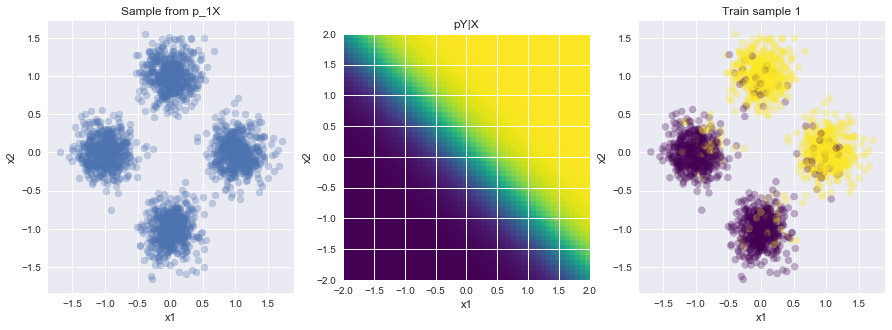

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X_train_1[:,0], X_train_1[:,1], alpha=0.3)
plt.title('Sample from p_1X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
dist_pyx_img = true_pyx(x).numpy().reshape((N, N))
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=Y_train_1, alpha=0.3)
plt.title('Train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

Compared to the XOR problem, this one is somewhere separable, somewhere not.

Text(0, 0.5, 'y')

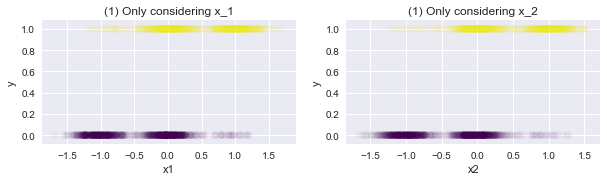

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.scatter(X_train_1[:,0], Y_train_1, c=Y_train_1, alpha=0.03)
plt.title('(1) Only considering x_1'); plt.xlabel('x1'); plt.ylabel('y')
plt.subplot(2, 2, 2)
plt.scatter(X_train_1[:,1], Y_train_1, c=Y_train_1, alpha=0.03)
plt.title('(1) Only considering x_2'); plt.xlabel('x2'); plt.ylabel('y')

As before, we can compute the ground-truth attribution solution analytically.

We will make a small approximation to simplify the computation, we sharpen the sigmoid of $p(y|x)$ to a step function:
$$\tilde{p}(y=1|x) = \mathbb{H}(x_1 + x_2)$$

We plot again the distribution for the two tasks with this approximation to show that it does not change much the task.

Text(0, 0.5, 'x2')

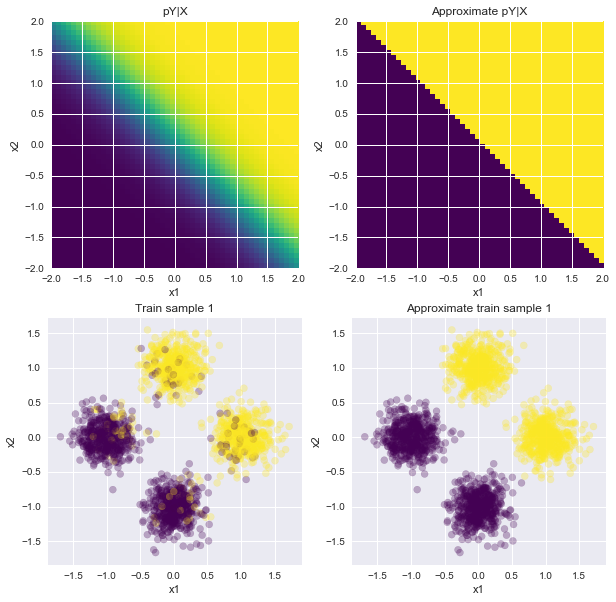

In [29]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
dist_pyx_img = true_pyx(x).numpy().reshape((N, N))
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 2)
plt.imshow(np.round(dist_pyx_img), extent=[-2, 2, -2, 2], origin='lower')
plt.title('Approximate pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=Y_train_1, alpha=0.3)
plt.title('Train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=np.round(true_pyx(X_train_1).numpy()), alpha=0.3)
plt.title('Approximate train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

The attribution solutions won't be much different with this approximation, just a bit less noisy.

_Problem (1):_

$p(X)$ is a mixture of four gaussians with independent components, that we denote $C_i$. 

$$ p(Y=1|X_1=x_1) = P(X_1 + X_2 > 0 | X_1 = x_1) = P(X_2 > -x_1, X_1 = x_1)/p(X_1 = x_1)$$

$$ = \sum\limits_{i=1}^4 P(X_2 > -x_1, X_1 = x_1 \mid C_i)P(C_i)/p(X_1 = x_1) $$ 

$$ = \sum\limits_{i=1}^4 P(X_2 > -x_1 \mid C_i) p(X_1 = x_1 \mid C_i) P(C_i)/p(X_1 = x_1) $$ 

$$= \frac{\sum\limits_{i=1}^4 P(X_2 > -x_1 \mid C_i) p(X_1 = x_1 \mid C_i)}{\sum_1^4  p(X_1 = x_1 \mid C_i)}$$ 

$$= \frac{\sum\limits_{i=1}^4  P \left( \mathcal{N}((\mu_i)_2, \sigma) > -x_1 \right) \mathcal{N}(x_1; (\mu_i)_1, \sigma) }{\sum_1^4  \mathcal{N}(x_1; (\mu_i)_1, \sigma)}$$

Note that, $\forall i, P(C_i) = \frac{1}{4}$. We obtain the probability as a mean of four normal quantiles of the four clusters with mean $\mu_i$.

As the task is symmetric, we have the same function shape for the study of $p(Y=1|X_2=x_2)$.

In [30]:
def normal(x, mu, sig):
    return tf.exp( -tf.square(x-mu)/(2*sig**2) ) / ( sig*tf.math.sqrt(2*np.pi) )

def quantile(x, mu, sig):
    return 0.5 * (1 + tf.math.erf((x - mu)/(tf.sqrt(2.)*sig) ))

def pyx1_task1(x1, mu=1, sig=0.2):
    px1 = normal(x1, -mu, sig)
    px23 = normal(x1, 0, sig)
    px4 = normal(x1, mu, sig)
    eyx = ( (1 - quantile(-x1, 0, sig)) * px1     # cluster (-mu, 0)
        + (1 - quantile(-x1, -mu, sig)) * px23     # cluster (0, -mu)
        + (1 - quantile(-x1, mu, sig)) * px23     # cluster (0, mu)
        + (1 - quantile(-x1, 0, sig)) * px4   # cluster (mu, 0)
        ) / (px1 + 2*px23 + px4)
    return eyx

Text(0, 0.5, 'y')

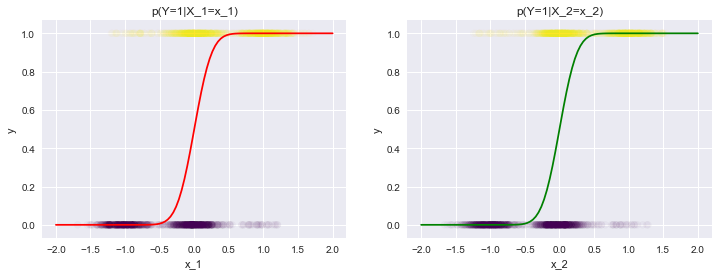

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X_train_1[:,0], Y_train_1, c=Y_train_1, alpha=0.03)
x1_ = tf.convert_to_tensor(np.linspace(-2, 2, 100), 'float32')
eyx_= pyx1_task1(x1_, 0. * x1_)
plt.plot(x1_, eyx_, c='r')
plt.title('p(Y=1|X_1=x_1)'); plt.xlabel('x_1'); plt.ylabel('y')

plt.subplot(1,2,2)
plt.scatter(X_train_1[:,1], Y_train_1, c=Y_train_1, alpha=0.03)
x1_ = tf.convert_to_tensor(np.linspace(-2, 2, 100), 'float32')
eyx_= pyx1_task1(x1_, 0. * x1_)
plt.plot(x1_, eyx_, c='g')
plt.title('p(Y=1|X_2=x_2)'); plt.xlabel('x_2'); plt.ylabel('y')

We have plotted the probability distributions $p(Y=1|X_1)$ and $p(Y=1|X_2)$ with a sample of the data scattered in the background.

Now, back to the attribution problem, we want to find the regions where $p(Y|X) \simeq p(Y|X_S)$, with $S$ a minimal reduced subset of input variables indices that we can choose among $\{1\}$, $\{2\}$ or $\{1, 2\}$.

From the above graph, it is clear that
- $p(Y|X) \simeq p(Y|X_1)$ when $X_1 \lesssim -0.5$ and $X_1 \gtrsim 0.5$
- $p(Y|X) \simeq p(Y|X_2)$ when $X_2 \lesssim -0.5$ and $X_2 \gtrsim 0.5$
- if none of the above apply, we default to the whole input space for which we trivially have $p(Y|X) = p(Y|X_{1,2})$.

So we have our subset attribution solution.

In [32]:
def subset_attribution_task1(x):
    attr_x1 = tf.cast(x[:,0:1] < -0.5, 'float32') + tf.cast(x[:,0:1] > 0.5, 'float32')
    attr_x2 = tf.cast(x[:,1:2] < -0.5, 'float32') + tf.cast(x[:,1:2] > 0.5, 'float32')
    # if none of the above apply
    attr_x12 = (1 - attr_x1) * (1 - attr_x2)
    return tf.concat([attr_x1, attr_x2, attr_x12], axis=-1)

def subset_2_feature_attribution(a):
    '''
    Post-hoc methods provide feature attribution, not subset, we convert the x_1,2 attribution
    to a co-attribution to x_1 and x_2
    '''
    feat_attr = np.copy(a)
    feat_attr[:,0] = feat_attr[:,0] + feat_attr[:,2]
    feat_attr[:,1] = feat_attr[:,1] + feat_attr[:,2]
    feat_attr[:,2] = 0.
    return feat_attr

Text(0, 0.5, 'x2')

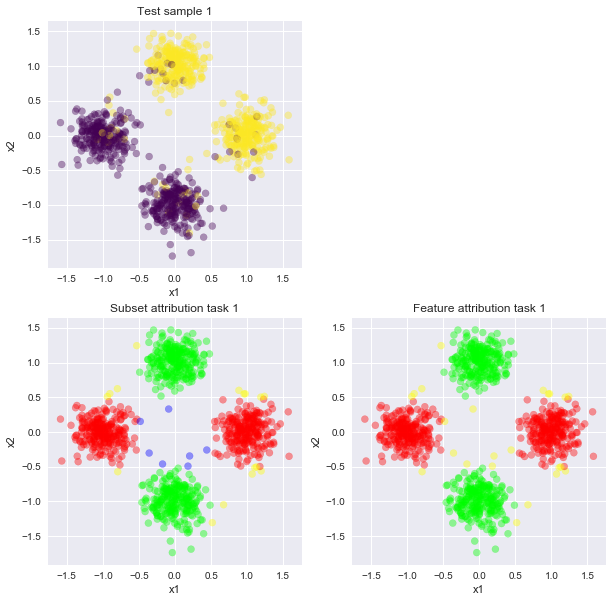

In [33]:
attr_test = subset_attribution_task1(X_test_1)
feat_attr_test = subset_2_feature_attribution(attr_test)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=Y_test_1, alpha=0.4)
plt.title('Test sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Subset attribution task 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Feature attribution task 1'); plt.xlabel('x1'); plt.ylabel('x2')

As a reminder, we display an attribution to subset $\{x_1\}$ with a <span style='color:#F00'>red</span> color, and $\{x_2\}$ with <span style='color:#082'>green</span>.

Because of the way the input distribution is, there is no significant difference between subset attribution and feature attribution: the attribution is most of the time a single feature.

**Ok, we have a task and a ground-truth local attribution, let's see how the different methods fare**.

### a - Gradient

Text(0, 0.5, 'x2')

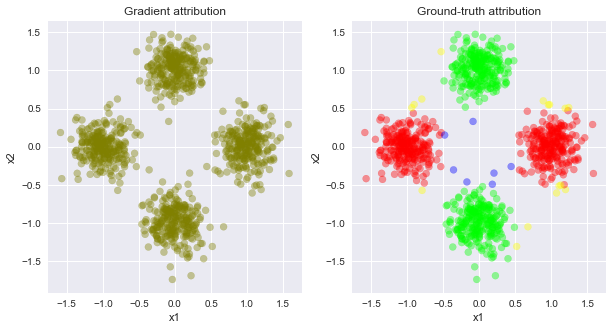

In [34]:
simple_grad = tf.abs(true_grad_pyx(X_test_1))
simple_grad = l1_normalisation(simple_grad)
simple_grad_img = np.zeros((X_test_1.shape[0], 3))
simple_grad_img[:,:2] = simple_grad.numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=simple_grad_img, alpha=0.4)
plt.title('Gradient attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 2, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')


Unsurprinsingly wrong, we already knew that gradient method did not provide an attribution solution.

As before, we also look at the gradient time input solution.

Text(0, 0.5, 'x2')

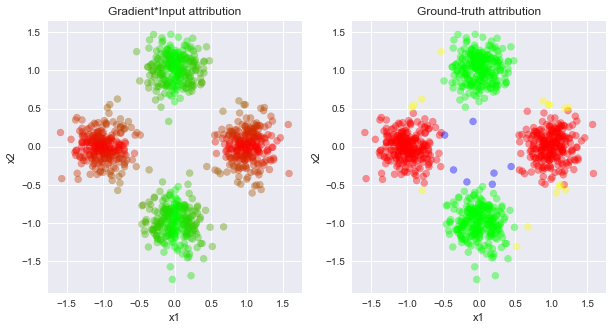

In [35]:
grad_input = tf.abs(true_grad_pyx(X_test_1) * X_test_1)
grad_input = l1_normalisation(grad_input)
grad_input_img = np.zeros((X_test_1.shape[0], 3))
grad_input_img[:,:2] = grad_input.numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=grad_input_img, alpha=0.4)
plt.title('Gradient*Input attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 2, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Again, at first glance we have the right solution! However, as before, this method is not robust to a global shift of the distribution, **which does not change the attribution solution**.

Note that in the above code, we shift both $p(X)$ and $p(Y|X)$, so the gradient of the shifted distribution stays the same, we can use the same expression `true_grad_pyx(X_test_1)` to avoid having to define a shifted gradient of $p(Y|X)$.

Text(0, 0.5, 'x2')

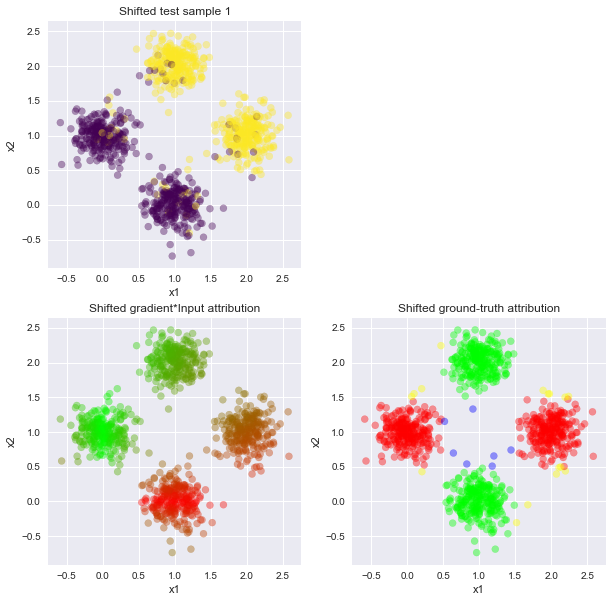

In [36]:
shift_X_test_1 = X_test_1 + np.array([[1., 1.]], 'float32')

shift_grad = true_grad_pyx(X_test_1)
shift_grad_input = l1_normalisation( tf.abs(shift_grad * shift_X_test_1) )
shift_grad_input_img = np.zeros((X_test_1.shape[0], 3))
shift_grad_input_img[:,:2] = shift_grad_input.numpy()

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(shift_X_test_1[:,0], shift_X_test_1[:,1], c=Y_test_1, alpha=0.4)
plt.title('Shifted test sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.scatter(shift_X_test_1[:,0], shift_X_test_1[:,1], c=shift_grad_input_img, alpha=0.4)
plt.title('Shifted gradient*Input attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.scatter(shift_X_test_1[:,0], shift_X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Shifted ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

As before, the gradient time input method does not work properly when we shift the data. It's is already surprinsing that it sometime works.

### b - LIME

In [37]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_1, discretize_continuous=False)

predictor = wrap_prob(true_pyx)
lime_attr = np.zeros((X_test_1.shape[0], 3))
for i, point in enumerate(X_test_1):
    exp = explainer.explain_instance(point.numpy(), predictor, num_features=2, num_samples=1000).as_list()
    lime_attr[i,int(exp[0][0])] = exp[0][1]
    lime_attr[i,int(exp[0][1])] = exp[1][1]

Text(0, 0.5, 'x2')

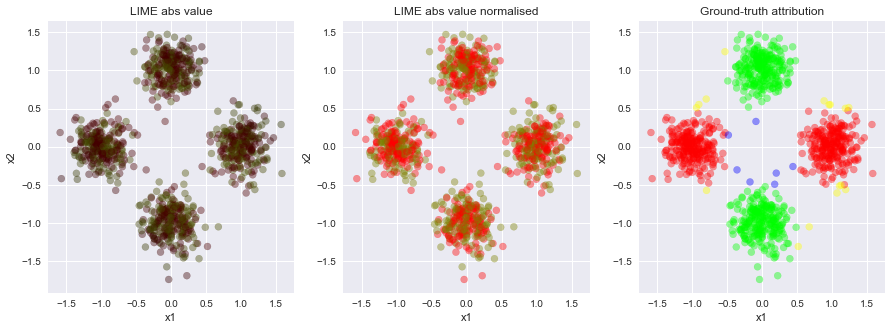

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=np.abs(lime_attr), alpha=0.4)
plt.title('LIME abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=l1_normalisation(np.abs(lime_attr)), alpha=0.4)
plt.title('LIME abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Because LIME solves the sensitivity task and the conditional distribution $p(y|x)$ is quite constant on the clusters, the interpreted values are very low, so the normalisation just brings up the noise.

### c - Integrated Gradient

As before, we indicate the baseline point with a red cross. We first choose the origin as baseline. Then, we can choose any point along the line $x_1 + x_2 = 0$, which are as relevant as the origin as a point with equiprobable label, but now breaking the symmetry we have with the origin that may be a particular case.

In [39]:
intgrad_attr = np.zeros((X_test_1.shape[0], 3))
baseline_point = np.array([0., 0.], 'float32')

for i, point in enumerate(X_test_1):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_attr[i,:2] = exp

Text(0, 0.5, 'x2')

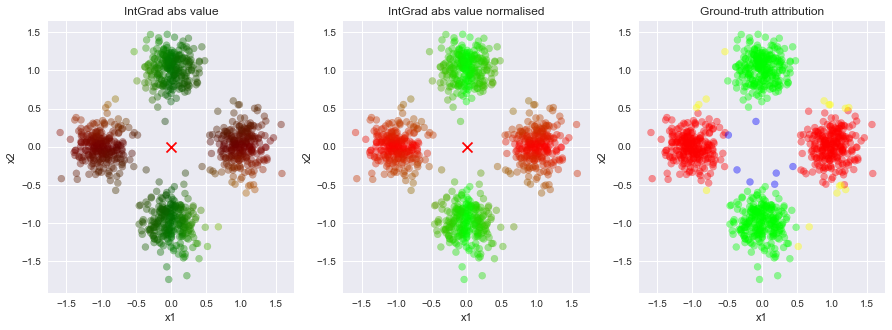

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=np.abs(intgrad_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=l1_normalisation(np.abs(intgrad_attr)), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

We have the right solution with the origin as baseline. But this point is very particular since the term $(x-\textrm{baseline})$ forbids to have bivariate attributions. 

As mentioned, **we now move the baseline by a small displacement, to a baseline as relevant as the origin** to denote an absence of prediction: $(0.1, -0.1)$.

In [41]:
intgrad_alt_attr = np.zeros((X_test_1.shape[0], 3))
baseline_point = np.array([0.1, -0.1], 'float32')

for i, point in enumerate(shift_X_test_1):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_alt_attr[i,:2] = exp

intgrad_alt_attr = np.abs(intgrad_alt_attr)
intgrad_alt_attr = intgrad_alt_attr / np.max(intgrad_alt_attr)

Text(0, 0.5, 'x2')

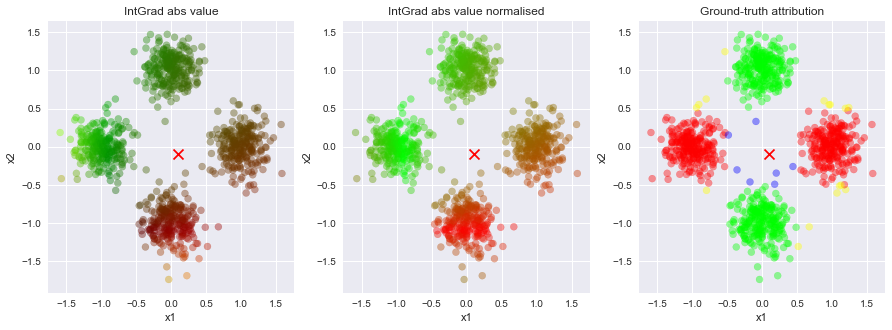

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=intgrad_alt_attr, alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=l1_normalisation(intgrad_alt_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Note that a baseline $(-1, 1)$ is not a small displacement but is still a relavant choice of a baseline (the label distribution is equiprobable there too. And we would obtain a drastically different and completely wrong solution.

Text(0, 0.5, 'x2')

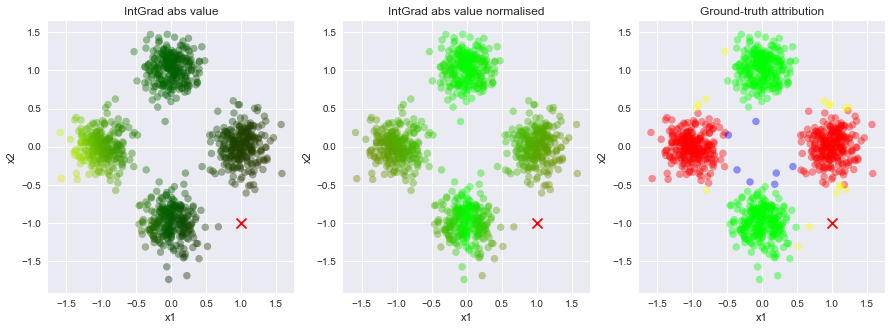

In [43]:
intgrad_alt_attr = np.zeros((X_test_1.shape[0], 3))
baseline_point = np.array([1, -1], 'float32')

for i, point in enumerate(shift_X_test_1):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_alt_attr[i,:2] = exp

intgrad_alt_attr = np.abs(intgrad_alt_attr)
intgrad_alt_attr = intgrad_alt_attr / np.max(intgrad_alt_attr)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=intgrad_alt_attr, alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=l1_normalisation(intgrad_alt_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Complete failure.

### d - SHAP

In [44]:
tf.keras.backend.clear_session()

inputs = Input((2,))
output = Lambda(true_pyx)(inputs)
predictor = tf.keras.Model(inputs, output)  # oracle

expl = shap.GradientExplainer(predictor, X_train_1, batch_size=500)

In [45]:
shap_val = expl.shap_values(X_test_1.numpy())

Text(0, 0.5, 'x2')

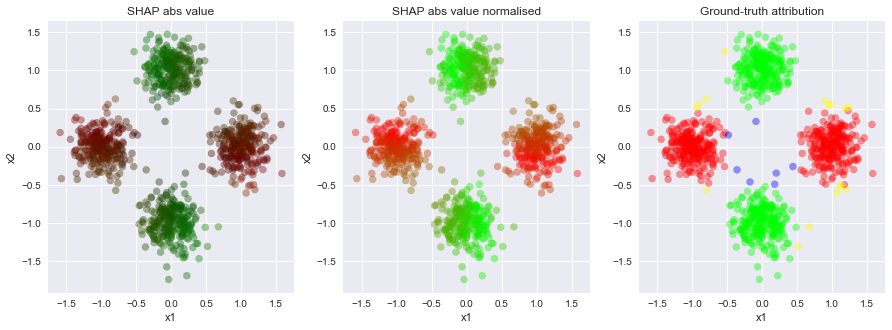

In [46]:
shap_attr = np.zeros((X_test_1.shape[0], 3))
shap_attr[:,:2] = shap_val.reshape((-1,2))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=np.abs(shap_attr), alpha=0.4)
plt.title('SHAP abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=l1_normalisation(np.abs(shap_attr)), alpha=0.4)
plt.title('SHAP abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

SHAP works properly!

### Conclusion

With the exception of **SHAP**, the post-hoc methods fail at returning the local univariate attribution solution.

### <span style='color:#00F'>Our method</span>

In [47]:
tf.keras.backend.clear_session()
params = {
    'input_dim': (2,),
    'hidden_layers_dims': [32, 16],
    'activation': 'relu',
    
    'input_node_partition': [(0, 1), (1, 2)],
    'attribution_subsets':  [(True, False), (False, True), (True, True)],  # all possible candidates
}

m = Attr_Binary_FF_list(params)
m.compile(tf.keras.optimizers.Adam(1e-3))

In [48]:
def batch_gen(bs=256):
    X_train = tf.convert_to_tensor(sample_true_px_1(bs), 'float32')  # p_X = U(-4,4) * U(-4,4)
    Y_train = sample(true_pyx(X_train))
    return X_train, Y_train

data_gen = make_generator(batch_gen, {})
m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 0.4503 - acc: 0.9295
Epoch 2/30
500/500 - 1s - loss: 0.4364 - acc: 0.9368
Epoch 3/30
500/500 - 1s - loss: 0.4364 - acc: 0.9365
Epoch 4/30
500/500 - 1s - loss: 0.4363 - acc: 0.9369
Epoch 5/30
500/500 - 1s - loss: 0.4375 - acc: 0.9361
Epoch 6/30
500/500 - 1s - loss: 0.4355 - acc: 0.9376
Epoch 7/30
500/500 - 1s - loss: 0.4361 - acc: 0.9373
Epoch 8/30
500/500 - 1s - loss: 0.4361 - acc: 0.9373
Epoch 9/30
500/500 - 1s - loss: 0.4359 - acc: 0.9371
Epoch 10/30
500/500 - 1s - loss: 0.4359 - acc: 0.9373
Epoch 11/30
500/500 - 1s - loss: 0.4366 - acc: 0.9364
Epoch 12/30
500/500 - 1s - loss: 0.4369 - acc: 0.9364
Epoch 13/30
500/500 - 1s - loss: 0.4371 - acc: 0.9361
Epoch 14/30
500/500 - 1s - loss: 0.4361 - acc: 0.9371
Epoch 15/30
500/500 - 1s - loss: 0.4356 - acc: 0.9372
Epoch 16/30
500/500 - 1s - loss: 0.4356 - acc: 0.9375
Epoch 17/30
500/500 - 1s - loss: 0.4349 - acc: 0.9380
Epoch 18/30
500/500 - 1s - loss: 0.4350 - acc: 0.9380
Epoch 19/30
500/500 - 1s - loss: 0.43

Text(0, 0.5, 'x2')

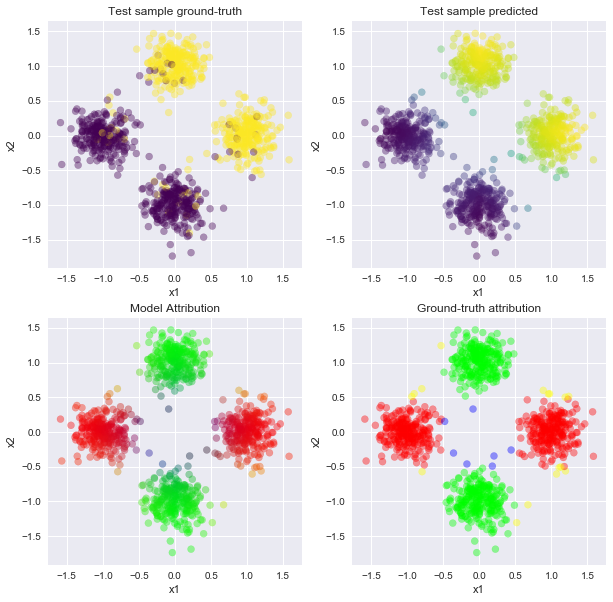

In [49]:
pred_experts = m.model_int.predict(X_test_1)
attr = get_attributions(pred_experts, m.C_residual)
pred = MoE(pred_experts, m.C_residual, mode='L1').numpy().reshape(-1) * 2. - 1
attr_img = attr.numpy().reshape((-1, 3))

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=Y_test_1, alpha=0.4)
plt.title('Test sample ground-truth'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,2)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=pred.reshape(-1), alpha=0.4)
plt.title('Test sample predicted'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,3)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_img, alpha=0.4)
plt.title('Model Attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,4)
plt.scatter(X_test_1[:,0], X_test_1[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

## 3 - Toy problem (d): a study on <span style='color:#00F'>local high-order attribution</span>


We move to a slightly more difficult task by designing a distribution where the attribution is sometimes bivariate, sometimes univariate.

We use the opportunity of a new section to highlight something very important most post-hoc miss: they do not consider $p_X$ in the computation of their interpretation. To demonstrate this, instead of considering a completely different task, **we use the same conditional probability $p(y|x)$ as the previous section** but with a different input distributions $p_2(x)$.

$$X \sim \frac{1}{4} \left[ \mathcal{N}((-\mu, -2\mu), \sigma) + \mathcal{N}((-\mu, 0), \sigma) + \mathcal{N}((\mu, 0), \sigma) + \mathcal{N}((\mu, 2\mu), \sigma) \right]$$

If you look closely, two normal clusters remain unchanged, two are moved along the line $x_1+x_2 = 0$.

Meanwhile, $p(Y=1|x)$ is the same: $\textrm{sigmoid}(x_1 + x_2)$.

We plot the same figures as before and compute the ground-truth attribution on this task.

In [50]:
def sample_true_px_2(bs = 256, mu = 1, sig = 0.2):
    ''' 4 gaussian distributions but organised differently '''
    X = np.random.normal(0, sig, (bs, 2))
    s = bs // 4
    X[:s] = X[:s] + [-mu, 2*mu]
    X[s:(2*s)] = X[s:(2*s)] + [-mu, 0]
    X[(2*s):(3*s)] = X[(2*s):(3*s)] + [mu, 0]
    X[(3*s):] = X[(3*s):] + [mu, -2*mu]
    return X

In [51]:
X_train_2 = tf.convert_to_tensor(sample_true_px_2(bs = 2000), 'float32')
Y_train_2 = sample(true_pyx(X_train_2))  # note: we use the same mapping X -> Y as previous section

X_test_2 = tf.convert_to_tensor(sample_true_px_2(bs = 1000), 'float32')
Y_test_2 = sample(true_pyx(X_test_2))

Text(0, 0.5, 'x2')

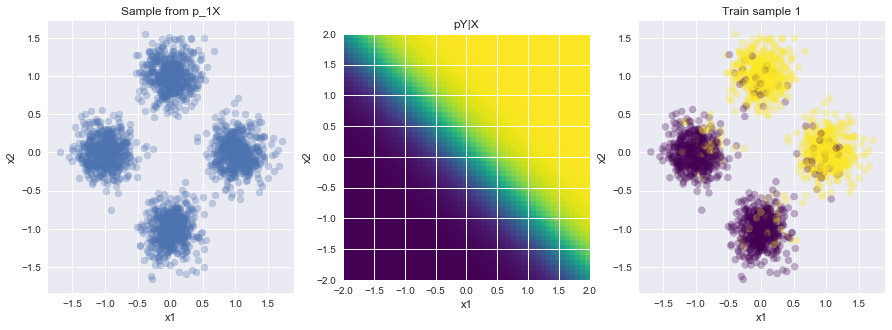

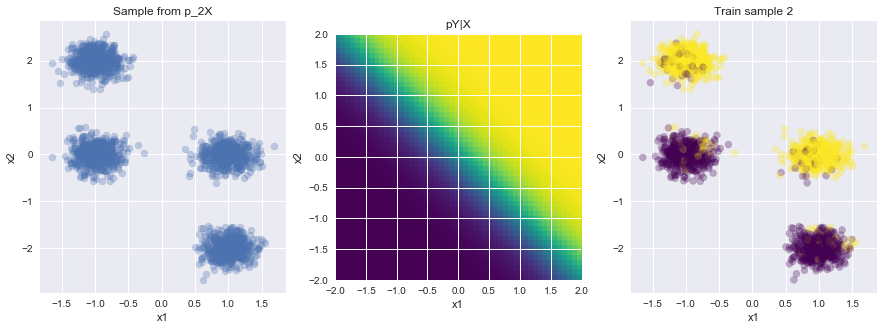

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X_train_1[:,0], X_train_1[:,1], alpha=0.3)
plt.title('Sample from p_1X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
dist_pyx_img = true_pyx(x).numpy().reshape((N, N))
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=Y_train_1, alpha=0.3)
plt.title('Train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')


plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X_train_2[:,0], X_train_2[:,1], alpha=0.3)
plt.title('Sample from p_2X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_train_2[:,0], X_train_2[:,1], c=Y_train_2, alpha=0.3)
plt.title('Train sample 2'); plt.xlabel('x1'); plt.ylabel('x2')

Text(0, 0.5, 'y')

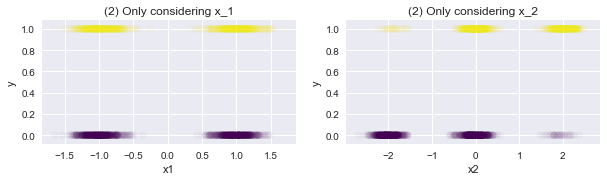

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(2, 2, 3)
plt.scatter(X_train_2[:,0], Y_train_2, c=Y_train_2, alpha=0.03)
plt.title('(2) Only considering x_1'); plt.xlabel('x1'); plt.ylabel('y')
plt.subplot(2, 2, 4)
plt.scatter(X_train_2[:,1], Y_train_2, c=Y_train_2, alpha=0.03)
plt.title('(2) Only considering x_2'); plt.xlabel('x2'); plt.ylabel('y')

Text(0, 0.5, 'x2')

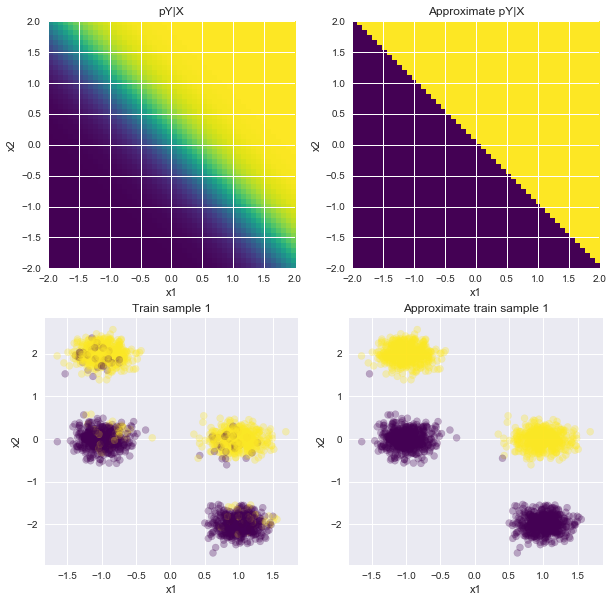

In [54]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
dist_pyx_img = true_pyx(x).numpy().reshape((N, N))
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 2)
plt.imshow(np.round(dist_pyx_img), extent=[-2, 2, -2, 2], origin='lower')
plt.title('Approximate pY|X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.scatter(X_train_2[:,0], X_train_2[:,1], c=Y_train_2, alpha=0.3)
plt.title('Train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.scatter(X_train_2[:,0], X_train_2[:,1], c=np.round(true_pyx(X_train_2).numpy()), alpha=0.3)
plt.title('Approximate train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

In [55]:
def pyx1_task2(x1, mu=1, sig=0.2):
    ''' We use the same formula as before, the only change is in the normal mean coordinates '''
    px12 = normal(x1, -mu, sig)
    px34 = normal(x1, mu, sig)
    eyx = ( (1 - quantile(-x1, 0, sig)) * px12     # cluster (-mu, 0)
        + (1 - quantile(-x1, 2*mu, sig)) * px12     # cluster (-mu, 2mu)
        + (1 - quantile(-x1, 0, sig)) * px34     # cluster (mu, 0)
        + (1 - quantile(-x1, -2*mu, sig)) * px34   # cluster (mu, -2mu)
        ) / (2 * px12 + 2 * px34)
    return eyx

def pyx2_task2(x2, mu=1, sig=0.2):
    px13 = normal(x2, 0, sig)
    px2 = normal(x2, 2*mu, sig)
    px4 = normal(x2, -2*mu, sig)
    eyx = ( (1 - quantile(-x2, -mu, sig)) * px13     # cluster (-mu, 0)
        + (1 - quantile(-x2, -mu, sig)) * px2     # cluster (-mu, 2mu)
        + (1 - quantile(-x2, mu, sig)) * px13     # cluster (mu, 0)
        + (1 - quantile(-x2, mu, sig)) * px4   # cluster (mu, -2mu)
        ) / (2 * px13 + px2 + px4)
    return eyx

Text(0, 0.5, 'y')

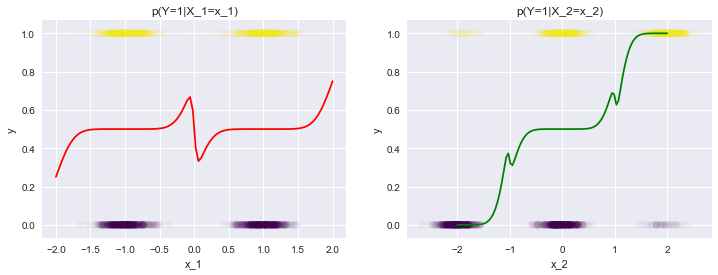

In [56]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(X_train_2[:,0], Y_train_2, c=Y_train_2, alpha=0.03)
x1_ = tf.convert_to_tensor(np.linspace(-2, 2, 100), 'float32')
eyx_1= pyx1_task2(x1_)
plt.plot(x1_, eyx_1, c='r')
plt.title('p(Y=1|X_1=x_1)'); plt.xlabel('x_1'); plt.ylabel('y')

plt.subplot(1,2,2)
plt.scatter(X_train_2[:,1], Y_train_2, c=Y_train_2, alpha=0.03)
x2_ = tf.convert_to_tensor(np.linspace(-2, 2, 100), 'float32')
eyx_2 = pyx2_task2(x2_)
plt.plot(x2_, eyx_2, c='g')
plt.title('p(Y=1|X_2=x_2)'); plt.xlabel('x_2'); plt.ylabel('y')

Despite the weird wiggles due to the mapping approximation, we can find a attribution solution with a reduced input set in some regions:

- $p(Y|X) \simeq p(Y|X_2)$ when $X_2 \lesssim -1.5$ and $X_2 \gtrsim 1.5$

As before, we otherwise fallback to the two input features.

In [57]:
def subset_attribution_task2(x):
    attr_x1 = tf.zeros((x.shape[0],1))
    attr_x2 = tf.cast(x[:,1:2] < -1.5, 'float32') + tf.cast(x[:,1:2] > 1.5, 'float32')
    # if none of the above apply
    attr_x12 = (1 - attr_x2)
    return tf.concat([attr_x1, attr_x2, attr_x12], axis=-1)


Text(0, 0.5, 'x2')

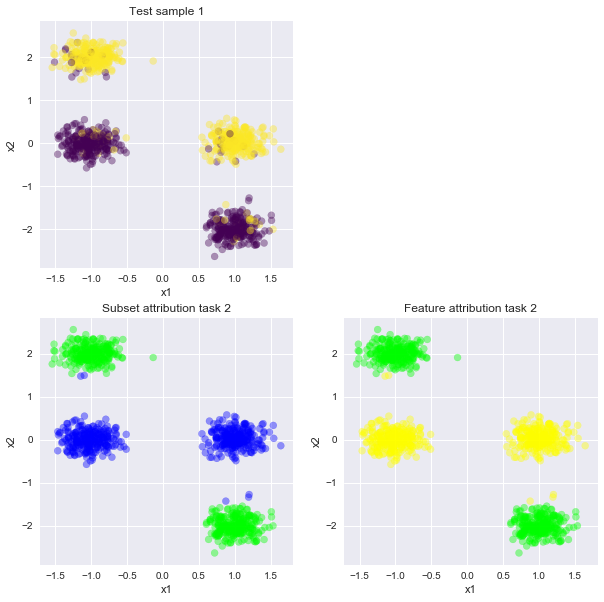

In [58]:
attr_test = subset_attribution_task2(X_test_2)
feat_attr_test = subset_2_feature_attribution(attr_test)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=Y_test_2, alpha=0.4)
plt.title('Test sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Subset attribution task 2'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Feature attribution task 2'); plt.xlabel('x1'); plt.ylabel('x2')

As a reminder, we display an attribution to subset $\{x_1\}$ with a <span style='color:#F00'>red</span> color, $\{x_2\}$ with <span style='color:#082'>green</span>, and $\{x_1, x_2\}$ with <span style='color:#00F'>blue</span>, or <span style='color:#D90'>yellow</span> if we consider only a feature attribution.

### a, b - Gradient and LIME

At this point, it is established that they don't work.

### c - Integrated Gradient

In [59]:
intgrad_attr = np.zeros((X_test_2.shape[0], 3))
baseline_point = np.array([0., 0.], 'float32')

for i, point in enumerate(X_test_2):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_attr[i,:2] = exp

intgrad_attr = np.abs(intgrad_attr) / np.max(np.abs(intgrad_attr))

Text(0, 0.5, 'x2')

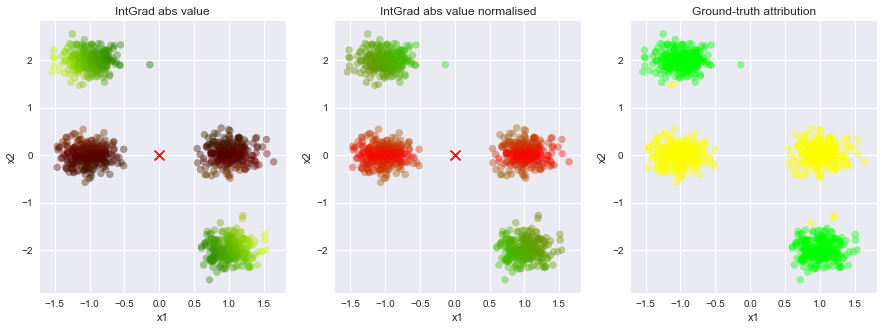

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=intgrad_attr, alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=l1_normalisation(intgrad_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Well, nope, wrong. And we did not even tamper with the baseline this time.

... but if we do, we obtain this.

Text(0, 0.5, 'x2')

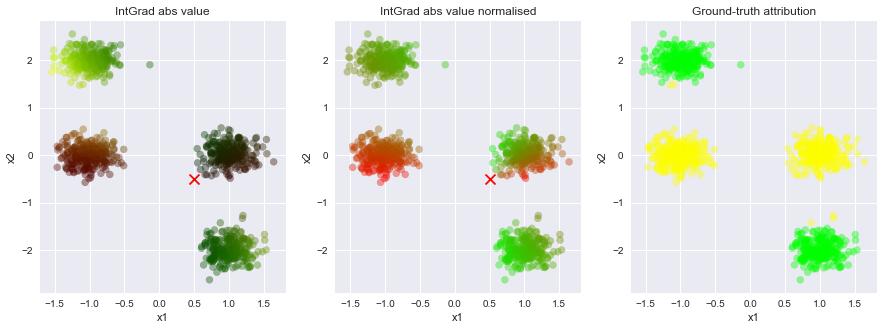

In [61]:
intgrad_attr = np.zeros((X_test_2.shape[0], 3))
baseline_point = np.array([0.5, -0.5], 'float32')

for i, point in enumerate(X_test_2):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_attr[i,:2] = exp

intgrad_attr = np.abs(intgrad_attr) / np.max(np.abs(intgrad_attr))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=intgrad_attr, alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=l1_normalisation(intgrad_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

... or this

Text(0, 0.5, 'x2')

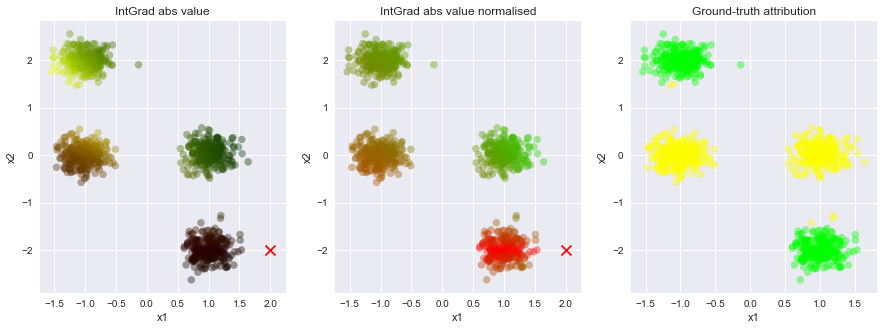

In [62]:
intgrad_attr = np.zeros((X_test_2.shape[0], 3))
baseline_point = np.array([2, -2], 'float32')

for i, point in enumerate(X_test_2):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_attr[i,:2] = exp

intgrad_attr = np.abs(intgrad_attr) / np.max(np.abs(intgrad_attr))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=intgrad_attr, alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=l1_normalisation(intgrad_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

And our auxiliary point is that this solution does not depend on the distribution of $X$, so the computation is the same as with the previous section, **while the attribution solution is completely different**.

### d - SHAP

In [63]:
tf.keras.backend.clear_session()

inputs = Input((2,))
output = Lambda(true_pyx)(inputs)
predictor = tf.keras.Model(inputs, output)  # oracle

expl = shap.GradientExplainer(predictor, X_train_2, batch_size=500)

In [64]:
shap_val = expl.shap_values(X_test_2.numpy())

Text(0, 0.5, 'x2')

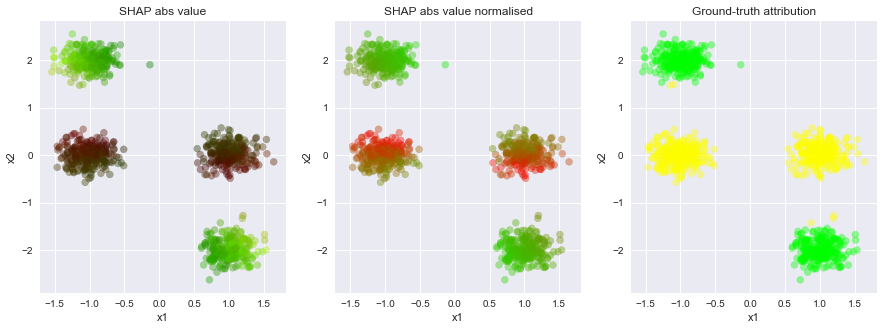

In [66]:
shap_attr = np.zeros((X_test_2.shape[0], 3))
shap_attr[:,:2] = shap_val.reshape((-1,2))
shap_attr = np.abs(shap_attr) / np.max(np.abs(shap_attr))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=shap_attr, alpha=0.4)
plt.title('SHAP abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=l1_normalisation(np.abs(shap_attr)), alpha=0.4)
plt.title('SHAP abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=feat_attr_test, alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

There is something. But it is conspicuous that SHAP cannot handle high-order interactions.

We point at an issue of SHAP in the following plot. Sometime we have multiple attribution solutions: here $x_1$ **or** $x_2$ alone is sufficient:

In [67]:
def sample_true_px_3(bs = 256, mu = 1, sig = 0.2):
    ''' 4 gaussian distributions but organised differently '''
    X = np.random.normal(0, sig, (bs, 2))
    s = bs // 4
    X[:s] = X[:s] + [-mu, 2*mu]
    X[s:(2*s)] = X[s:(2*s)] + [-mu, -mu]
    X[(2*s):(3*s)] = X[(2*s):(3*s)] + [mu, mu]
    X[(3*s):] = X[(3*s):] + [mu, -2*mu]
    return X

X_train_3 = tf.convert_to_tensor(sample_true_px_3(bs = 2000), 'float32')
Y_train_3 = sample(true_pyx(X_train_3))
X_test_3 = tf.convert_to_tensor(sample_true_px_3(bs = 500), 'float32')
Y_test_3 = sample(true_pyx(X_test_3))

In [68]:
tf.keras.backend.clear_session()

inputs = Input((2,))
output = Lambda(true_pyx)(inputs)
predictor = tf.keras.Model(inputs, output)  # oracle

expl = shap.GradientExplainer(predictor, X_train_3, batch_size=500)
shap_val = expl.shap_values(X_test_3.numpy())

Text(0, 0.5, 'x2')

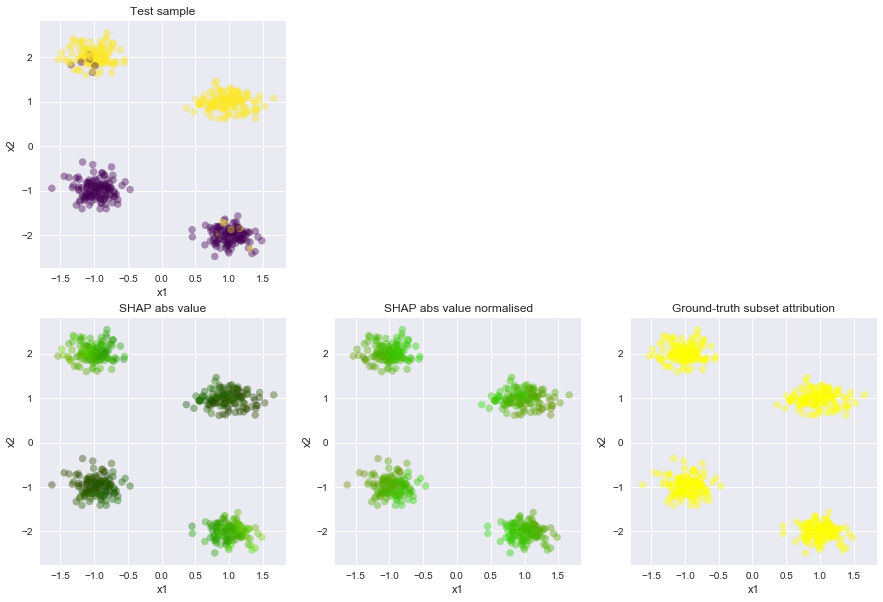

In [69]:
shap_attr = np.zeros((X_test_3.shape[0], 3))
shap_attr[:,:2] = shap_val.reshape((-1,2))

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=Y_test_3, alpha=0.4)
plt.title('Test sample'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 3, 4)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=np.abs(shap_attr), alpha=0.4)
plt.title('SHAP abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 3, 5)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=l1_normalisation(np.abs(shap_attr)), alpha=0.4)
plt.title('SHAP abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2, 3, 6)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=np.tile([[1., 1., 0.]], (X_test_3.shape[0], 1)), alpha=0.4)
plt.title('Ground-truth subset attribution'); plt.xlabel('x1'); plt.ylabel('x2')

### <span style='color:#00F'>Our method</span>

In [70]:
tf.keras.backend.clear_session()
params = {
    'input_dim': (2,),
    'hidden_layers_dims': [32, 16],
    'activation': 'relu',
    
    'input_node_partition': [(0, 1), (1, 2)],
    'attribution_subsets':  [(True, False), (False, True), (True, True)],  # all possible candidates
}

m = Attr_Binary_FF_list(params)
m.compile(tf.keras.optimizers.Adam(1e-3))

In [71]:
def batch_gen(bs=256):
    X_train = tf.convert_to_tensor(sample_true_px_2(bs), 'float32')  # p_X = U(-4,4) * U(-4,4)
    Y_train = sample(true_pyx(X_train))
    return X_train, Y_train

data_gen = make_generator(batch_gen, {})
m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 0.4952 - acc: 0.9256
Epoch 2/30
500/500 - 1s - loss: 0.4830 - acc: 0.9365
Epoch 3/30
500/500 - 1s - loss: 0.4818 - acc: 0.9372
Epoch 4/30
500/500 - 1s - loss: 0.4827 - acc: 0.9364
Epoch 5/30
500/500 - 1s - loss: 0.4817 - acc: 0.9375
Epoch 6/30
500/500 - 1s - loss: 0.4832 - acc: 0.9358
Epoch 7/30
500/500 - 1s - loss: 0.4822 - acc: 0.9364
Epoch 8/30
500/500 - 1s - loss: 0.4817 - acc: 0.9374
Epoch 9/30
500/500 - 1s - loss: 0.4806 - acc: 0.9381
Epoch 10/30
500/500 - 1s - loss: 0.4813 - acc: 0.9380
Epoch 11/30
500/500 - 1s - loss: 0.4817 - acc: 0.9373
Epoch 12/30
500/500 - 1s - loss: 0.4819 - acc: 0.9370
Epoch 13/30
500/500 - 1s - loss: 0.4826 - acc: 0.9367
Epoch 14/30
500/500 - 1s - loss: 0.4824 - acc: 0.9366
Epoch 15/30
500/500 - 1s - loss: 0.4818 - acc: 0.9371
Epoch 16/30
500/500 - 1s - loss: 0.4828 - acc: 0.9362
Epoch 17/30
500/500 - 1s - loss: 0.4830 - acc: 0.9360
Epoch 18/30
500/500 - 1s - loss: 0.4826 - acc: 0.9367
Epoch 19/30
500/500 - 1s - loss: 0.48

Text(0, 0.5, 'x2')

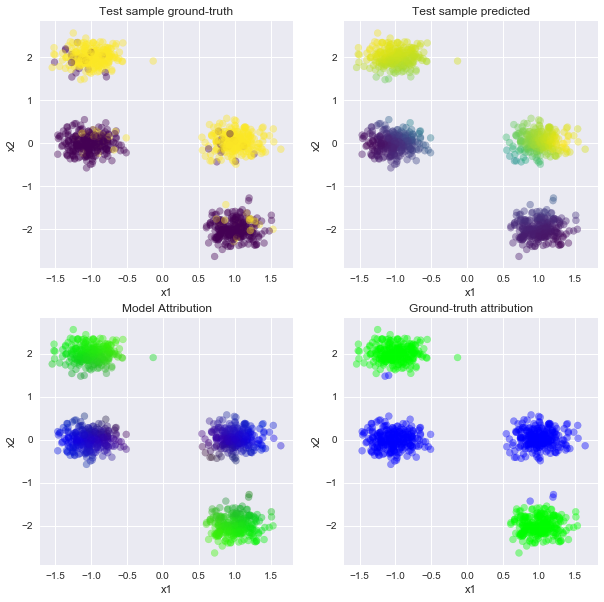

In [72]:
pred_experts = m.model_int.predict(X_test_2)
attr = get_attributions(pred_experts, m.C_residual)
pred = MoE(pred_experts, m.C_residual, mode='L1').numpy().reshape(-1) * 2. - 1
attr_img = attr.numpy().reshape((-1, 3))

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=Y_test_2, alpha=0.4)
plt.title('Test sample ground-truth'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,2)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=pred.reshape(-1), alpha=0.4)
plt.title('Test sample predicted'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,3)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=attr_img, alpha=0.4)
plt.title('Model Attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,4)
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=attr_test.numpy(), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Yep, it works.

And, differently from SHAP, if we move the cluster a bit to allow two optimal solutions:

In [86]:
tf.keras.backend.clear_session()
params = {
    'input_dim': (2,),
    'hidden_layers_dims': [32, 16],
    'activation': 'relu',
    
    'input_node_partition': [(0, 1), (1, 2)],
    'attribution_subsets':  [(True, False), (False, True), (True, True)],  # all possible candidates
}

m = Attr_Binary_FF_list(params)
m.compile(tf.keras.optimizers.Adam(1e-3))

def batch_gen(bs=256):
    X_train = tf.convert_to_tensor(sample_true_px_3(bs), 'float32')  # p_X = U(-4,4) * U(-4,4)
    Y_train = sample(true_pyx(X_train))
    return X_train, Y_train

data_gen = make_generator(batch_gen, {})
m.fit(data_gen, epochs=30, steps_per_epoch=500, verbose=2)

Epoch 1/30
500/500 - 1s - loss: 0.4885 - acc: 0.8293
Epoch 2/30
500/500 - 1s - loss: 0.4582 - acc: 0.8321
Epoch 3/30
500/500 - 1s - loss: 0.4614 - acc: 0.8295
Epoch 4/30
500/500 - 1s - loss: 0.4614 - acc: 0.8291
Epoch 5/30
500/500 - 1s - loss: 0.4605 - acc: 0.8293
Epoch 6/30
500/500 - 1s - loss: 0.4586 - acc: 0.8307
Epoch 7/30
500/500 - 1s - loss: 0.4572 - acc: 0.8313
Epoch 8/30
500/500 - 1s - loss: 0.4566 - acc: 0.8315
Epoch 9/30
500/500 - 1s - loss: 0.4568 - acc: 0.8313
Epoch 10/30
500/500 - 1s - loss: 0.4578 - acc: 0.8302
Epoch 11/30
500/500 - 1s - loss: 0.4568 - acc: 0.8304
Epoch 12/30
500/500 - 1s - loss: 0.4574 - acc: 0.8301
Epoch 13/30
500/500 - 1s - loss: 0.4550 - acc: 0.8313
Epoch 14/30
500/500 - 1s - loss: 0.4592 - acc: 0.8283
Epoch 15/30
500/500 - 1s - loss: 0.4560 - acc: 0.8301
Epoch 16/30
500/500 - 1s - loss: 0.4557 - acc: 0.8301
Epoch 17/30
500/500 - 1s - loss: 0.4557 - acc: 0.8297
Epoch 18/30
500/500 - 1s - loss: 0.4541 - acc: 0.8310
Epoch 19/30
500/500 - 1s - loss: 0.45

Text(0, 0.5, 'x2')

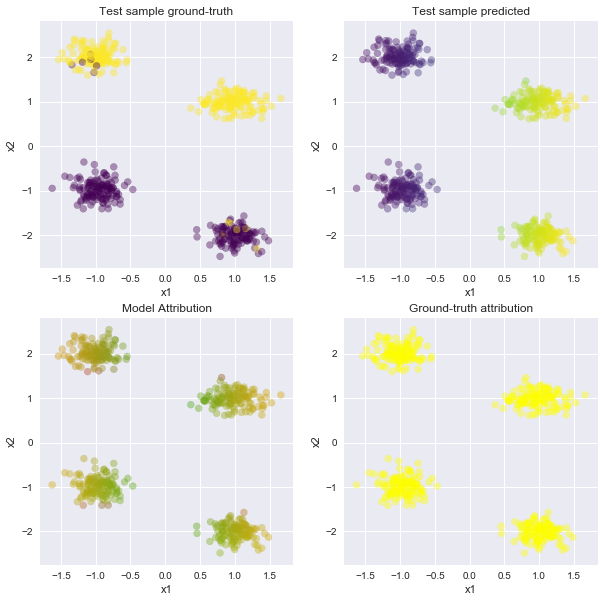

In [87]:
pred_experts = m.model_int.predict(X_test_3)
attr = get_attributions(pred_experts, m.C_residual)
pred = MoE(pred_experts, m.C_residual, mode='L1').numpy().reshape(-1) * 2. - 1
attr_img = attr.numpy().reshape((-1, 3))

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=Y_test_3, alpha=0.4)
plt.title('Test sample ground-truth'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,2)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=pred.reshape(-1), alpha=0.4)
plt.title('Test sample predicted'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,3)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=attr_img, alpha=0.4)
plt.title('Model Attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(2,2,4)
plt.scatter(X_test_3[:,0], X_test_3[:,1], c=np.tile([[1., 1., 0.]], (X_test_3.shape[0], 1)), alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

It is not perfectly clean, but at least we return the two solutions.

## 4 - Bonus: simple <span style='color:#00F'>global univariate attribution</span>

We studied problems that were surprinsingly difficult for the methods to solve, we show the attribution on a simple global univariate attribution binary problem with one informative variable and one nuisance variable.

$$X \sim \mathcal{U}([-2, 2]^2)$$
$$p(Y=1|X=x) = (1-2\eta)\frac{1 + \sin(x_1)}{2} + \eta$$ 

The data distribution is a sinus in $x_1$ with an global noise level $\eta$.

In [75]:
def sample_px(bs=256):
    return tf.random.uniform((bs, 2), -2, 2)

def true_pyx(x, eta = 0.1):
    return (1 - 2 * eta) * (tf.math.sin(x[:,0]) + 1) / 2 + eta

def true_grad_pyx(x, eta = 0.1):
    grad_x1 = (1 - 2 * eta) * tf.math.cos(x[:,0:1]) / 2
    return tf.concat([grad_x1, 0. * grad_x1], axis=-1)

In [76]:
X_train = sample_px(2000)
Y_train = sample(true_pyx(X_train))
X_test = sample_px(500)
Y_test = sample(true_pyx(X_test))

N = 50
gx, gy = np.meshgrid(np.linspace(-2, 2, N), np.linspace(-2, 2, N))
G = np.concatenate([gx.reshape((-1, 1)), gy.reshape((-1, 1))], axis=-1)
x = tf.convert_to_tensor(G, 'float32')

Text(0, 0.5, 'x2')

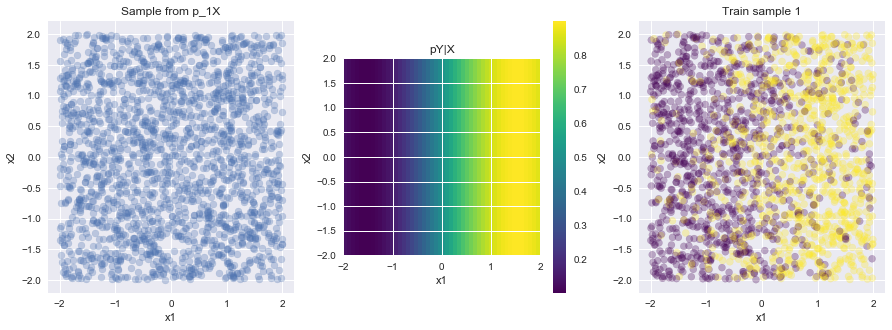

In [77]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.3)
plt.title('Sample from p_1X'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
dist_pyx_img = true_pyx(x).numpy().reshape((N, N))
plt.imshow(dist_pyx_img, extent=[-2, 2, -2, 2], origin='lower')
plt.title('pY|X'); plt.xlabel('x1'); plt.ylabel('x2')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, alpha=0.3)
plt.title('Train sample 1'); plt.xlabel('x1'); plt.ylabel('x2')

p(Y=1|X) only depends on $x_1$, and the task is uniform along $x_2$, thus the attribution is $\{x_1\}$ everywhere.

### a - Gradient

Text(0, 0.5, 'x2')

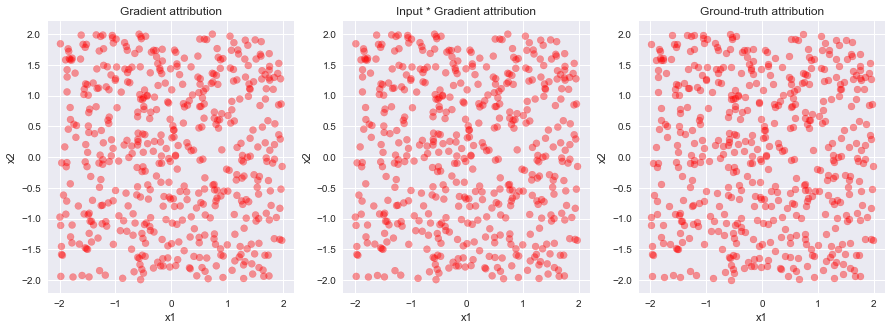

In [78]:
simple_grad = tf.abs(true_grad_pyx(X_test))
grad_input = tf.abs(simple_grad * X_test)

simple_grad = l1_normalisation(simple_grad)
grad_input = l1_normalisation(grad_input)
simple_grad_img = np.zeros((X_test.shape[0], 3))
simple_grad_img[:,:2] = simple_grad.numpy()
grad_input_img = np.zeros((X_test.shape[0], 3))
grad_input_img[:,:2] = grad_input.numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=simple_grad_img, alpha=0.4)
plt.title('Gradient attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=grad_input_img, alpha=0.4)
plt.title('Input * Gradient attribution'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c='r', alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')


It does work.

### b - LIME

In [79]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=False)

predictor = wrap_prob(true_pyx)
lime_attr = np.zeros((X_test.shape[0], 3))
for i, point in enumerate(X_test):
    exp = explainer.explain_instance(point.numpy(), predictor, num_features=2, num_samples=1000).as_list()
    lime_attr[i,int(exp[0][0])] = exp[0][1]
    lime_attr[i,int(exp[0][1])] = exp[1][1]

Text(0, 0.5, 'x2')

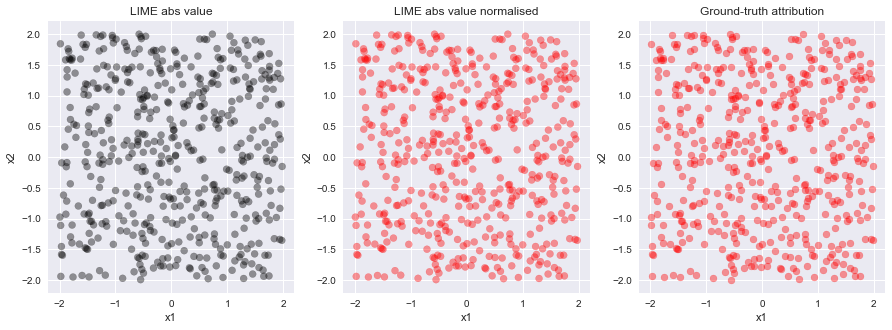

In [80]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=np.abs(lime_attr), alpha=0.4)
plt.title('LIME abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=l1_normalisation(np.abs(lime_attr)), alpha=0.4)
plt.title('LIME abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c='r', alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

It works when strongly normalised.

### c - IntGrad

In [81]:
intgrad_attr = np.zeros((X_test.shape[0], 3))
baseline_point = np.array([0., 0.], 'float32')

for i, point in enumerate(X_test):
    exp = integrated_gradients(baseline_point, point, true_grad_pyx)
    intgrad_attr[i,:2] = exp

Text(0, 0.5, 'x2')

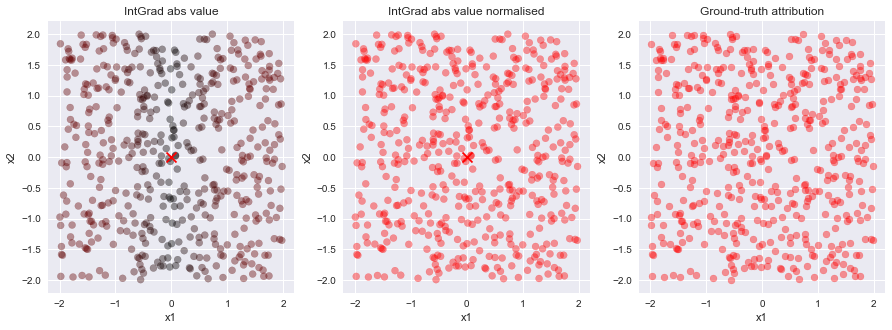

In [82]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=np.abs(intgrad_attr), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=l1_normalisation(np.abs(intgrad_attr)), alpha=0.4)
plt.scatter(baseline_point[0], baseline_point[1], s=100, c='r', marker='x')
plt.title('IntGrad abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c='r', alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

It works when normalised.

### d - SHAP

In [83]:
tf.keras.backend.clear_session()

inputs = Input((2,))
output = Lambda(true_pyx)(inputs)
predictor = tf.keras.Model(inputs, output)  # oracle

expl = shap.GradientExplainer(predictor, X_train, batch_size=500)

In [84]:
shap_val = expl.shap_values(X_test.numpy())

Text(0, 0.5, 'x2')

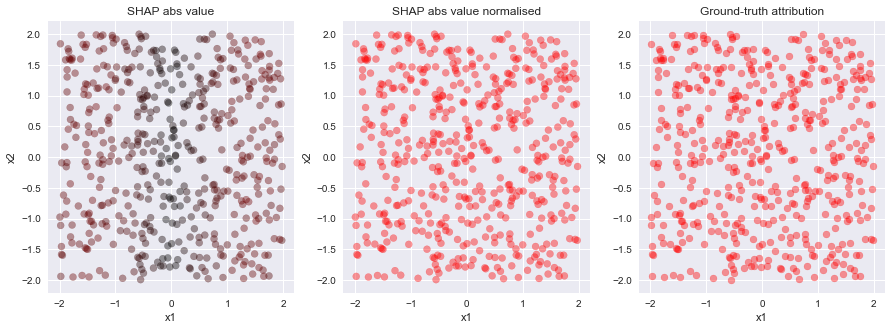

In [85]:
shap_attr = np.zeros((X_test.shape[0], 3))
shap_attr[:,:2] = shap_val.reshape((-1,2))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=np.abs(shap_attr), alpha=0.4)
plt.title('SHAP abs value'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=l1_normalisation(np.abs(shap_attr)), alpha=0.4)
plt.title('SHAP abs value normalised'); plt.xlabel('x1'); plt.ylabel('x2')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c='r', alpha=0.4)
plt.title('Ground-truth attribution'); plt.xlabel('x1'); plt.ylabel('x2')

Works when normalised.

### <span style='color:#00F'>Our method</span>

(todo: add, but yes, it is going to work)


### Conclusion

The post-hoc methods work on simple problems with an univariate global attribution. 